In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy

sys.path.append("/end/home/rh2310/morpho_repo")
import turing as tu
from turing.utils import *
import turing.loss_functions as tu_loss

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x_domain = L*np.linspace(0,1,x_size)
y_domain = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x_domain, y_domain, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

boundary_x_LB = np.concatenate((x_domain, 
                                np.repeat(x_domain[0], y_size)))
boundary_x_RT = np.concatenate((x_domain, 
                                np.repeat(x_domain[-1], y_size))) 

boundary_y_LB = np.concatenate((np.repeat(y_domain[0], x_size),
                                y_domain))
boundary_y_RT = np.concatenate((np.repeat(y_domain[-1], x_size),
                                y_domain)) 

boundary_XX_LB = np.tile(boundary_x_LB.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_XX_RT = np.tile(boundary_x_RT.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_YY_LB = np.tile(boundary_y_LB.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_YY_RT = np.tile(boundary_y_RT.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_TT = np.repeat(t_star[-T:], (x_size + y_size))[:, np.newaxis] # T x (x_size + y_size), 1


def create_dataset(training_data_size =  T*16,
                   pde_data_size =  (T*N)//(32),
                   boundary_data_size = ((x_size + y_size)*T)//(8),
                   with_boundary = True,
                   signal_to_noise = 0):
    
    ##########################################
    # Including noise
    if signal_to_noise > 0:
        signal_amp_a = (np.max(AA)-np.min(AA))/2.0
        signal_amp_s = (np.max(SS)-np.min(SS))/2.0  
        sigma_a =  signal_amp_a*signal_to_noise
        sigma_s =  signal_amp_s*signal_to_noise
    # Observed data
    idx_data = np.random.choice(N*T, training_data_size, replace=False)
    # PDE colocations
    idx_pde = np.random.choice(N*T, pde_data_size, replace=False)
    # Periodic boundary condition
    idx_boundary = np.random.choice((x_size + y_size)*T, boundary_data_size, replace=False)
    
    ret = {'obs_input': np.c_[XX[idx_data], YY[idx_data],TT[idx_data]],
           'obs_output': np.c_[AA[idx_data], SS[idx_data]],
           'pde':   np.c_[XX[idx_pde], YY[idx_pde], TT[idx_pde]]}
    
    if signal_to_noise > 0:        
        ret['obs_output'][0] += sigma_a * np.random.randn(len(idx_data), a.shape[1])
        ret['obs_output'][1] += sigma_s * np.random.randn(len(idx_data), s.shape[1])
    
    if with_boundary:
        ret = {**ret,
               **{'boundary_LB': np.c_[boundary_XX_LB[idx_boundary], 
                                       boundary_YY_LB[idx_boundary],
                                       boundary_TT[idx_boundary]],
                  'boundary_RT': np.c_[boundary_XX_RT[idx_boundary],
                                       boundary_YY_RT[idx_boundary],
                                       boundary_TT[idx_boundary]]
                 }
              }
    return ret

def print_vals(name, value, actual=None):    
    
    if actual is not None and actual > 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f}, "
              f"relative: %{100*np.abs(actual-value)/(actual):0.8f}")
    elif actual is not None and actual == 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f} ")
        
    else:
        print(f"{name}: {value:0.8f}")
        


In [3]:
def print_model(model, D_a = 0.005, D_s = 0.2):
    
    
    sigma_s = model.losses[1].sigma_s.numpy()[0]
    rho_s = model.losses[1].rho_s.numpy()[0]

    sigma_a = model.losses[1].sigma_a.numpy()[0]
    rho_a = model.losses[1].rho_a.numpy()[0]
    mu_a = model.losses[1].mu_a.numpy()[0]
    kappa_a = model.losses[1].kappa_a.numpy()[0]



    print_vals("sigma_s", sigma_s*D_s, 0.02)
    print_vals("rho_s", rho_s*D_s, 0.02)
    print()    
    print_vals("sigma_a", sigma_a*D_a, 0.0)
    print_vals("rho_a", rho_a*D_a,0.01)
    print_vals("mu_a", mu_a*D_a, 0.01 )
    print_vals("kappa_a", kappa_a, 0.25)

In [4]:
model_params_1 = {'training_data_size': T*32,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

dataset = create_dataset(**model_params_1)
lb, ub = lower_upper_bounds([np.c_[XX, YY, TT]])
obs_X = dataset['obs_input']
obs_Y = dataset['obs_output']
pde_X = dataset['pde']

# First iteration: with penalising observation by 75, up to the point that the observation loss becomes less than PDE loss

In [5]:
pinn = tu.NN(layers, lb, ub)
loss_stack_1 = [tu_loss.Observations(pinn, obs_X, obs_Y, init_loss_weight=75.0),
                tu_loss.ASDM(pinn, pde_X)
               ]
model_1 = tu.TINN(pinn, loss_stack_1, optimizer=keras.optimizers.Adam())

2022-06-24 09:52:24.379597: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-24 09:52:24.379651: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ld-rendres10
2022-06-24 09:52:24.379664: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ld-rendres10
2022-06-24 09:52:24.379737: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 440.33.1
2022-06-24 09:52:24.379781: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 440.33.1
2022-06-24 09:52:24.379793: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 440.33.1


In [6]:
arr_losses_1, samples_params_1, _ = \
         model_1.train(40000,
                       batch_size=dataset['obs_input'].shape[0]//8, 
                       print_iter=100,
                       stop_threshold = 1.0,
                       regularised=False,
                       regularisation_freq=10,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:3129364.00
Loss_observations:3098965.34375000 
Loss_ASDM:30398.73925781 sigma_a:0:0.99204290, sigma_s:0:0.99200243, rho_a:0:0.99540591, rho_s:0:1.00455809, mu_a:0:1.00466037, kappa_a:0:0.99660635
Time:2.55

Epoch: 100, loss:320784.25
Loss_observations:320762.51562500 
Loss_ASDM:21.73250413 sigma_a:0:0.77528733, sigma_s:0:0.80876374, rho_a:0:0.75916636, rho_s:0:1.28642166, mu_a:0:1.25341511, kappa_a:0:1.02095783
Time:58.12

Epoch: 200, loss:320422.06
Loss_observations:320401.41406250 
Loss_ASDM:20.63159680 sigma_a:0:0.77288336, sigma_s:0:0.80540305, rho_a:0:0.76017410, rho_s:0:1.28361201, mu_a:0:1.25094533, kappa_a:0:1.02494860
Time:59.42

Epoch: 300, loss:320218.53
Loss_observations:320171.78906250 
Loss_ASDM:46.73675966 sigma_a:0:0.76848733, sigma_s:0:0.79841876, rho_a:0:0.76314223, rho_s:0:1.27744436, mu_a:0:1.24520850, kappa_a:0:1.03294361
Time:60.01

Epoch: 400, loss:319040.72
Loss_observations:319002.37890625 
Loss_ASDM:38.32915497 sigma_a:0:0.75599849, sigma_s:0:0.

Epoch: 3800, loss:1893.63
Loss_observations:1420.24903870 
Loss_ASDM:473.38116455 sigma_a:0:0.00000000, sigma_s:0:0.09016833, rho_a:0:1.71080554, rho_s:0:0.08864103, mu_a:0:1.71419430, kappa_a:0:0.24988057
Time:68.08

Epoch: 3900, loss:1723.95
Loss_observations:1253.26390076 
Loss_ASDM:470.68437576 sigma_a:0:0.00000000, sigma_s:0:0.09000893, rho_a:0:1.71773374, rho_s:0:0.08833469, mu_a:0:1.72003818, kappa_a:0:0.25055334
Time:65.33

Epoch: 4000, loss:1709.43
Loss_observations:1239.24577332 
Loss_ASDM:470.18798447 sigma_a:0:0.00000000, sigma_s:0:0.08988964, rho_a:0:1.72488749, rho_s:0:0.08893903, mu_a:0:1.72569144, kappa_a:0:0.25047973
Time:68.43

Epoch: 4100, loss:1662.29
Loss_observations:1191.40763855 
Loss_ASDM:470.88714981 sigma_a:0:0.00000000, sigma_s:0:0.09026520, rho_a:0:1.73143148, rho_s:0:0.08874611, mu_a:0:1.73163581, kappa_a:0:0.25077224
Time:68.76

Epoch: 4200, loss:2050.32
Loss_observations:1577.20938110 
Loss_ASDM:473.10631180 sigma_a:0:0.00000000, sigma_s:0:0.09007762, rh

Epoch: 7600, loss:1033.68
Loss_observations:565.28082275 
Loss_ASDM:468.39493561 sigma_a:0:0.01048412, sigma_s:0:0.09010364, rho_a:0:1.87504005, rho_s:0:0.08920919, mu_a:0:1.87776768, kappa_a:0:0.25564227
Time:68.25

Epoch: 7700, loss:928.12
Loss_observations:459.74053574 
Loss_ASDM:468.37908554 sigma_a:0:0.01248884, sigma_s:0:0.08972953, rho_a:0:1.88070858, rho_s:0:0.08905461, mu_a:0:1.88406420, kappa_a:0:0.25537005
Time:68.67

Epoch: 7800, loss:964.28
Loss_observations:495.63201904 
Loss_ASDM:468.64554596 sigma_a:0:0.01280712, sigma_s:0:0.08947026, rho_a:0:1.88536394, rho_s:0:0.08962134, mu_a:0:1.89138854, kappa_a:0:0.25574428
Time:68.21

Epoch: 7900, loss:954.20
Loss_observations:485.91371536 
Loss_ASDM:468.28673935 sigma_a:0:0.01422342, sigma_s:0:0.09000319, rho_a:0:1.89099705, rho_s:0:0.08924975, mu_a:0:1.89776933, kappa_a:0:0.25534341
Time:68.94

Epoch: 8000, loss:965.19
Loss_observations:497.24567795 
Loss_ASDM:467.94613647 sigma_a:0:0.01573371, sigma_s:0:0.08955494, rho_a:0:1.8

Epoch: 11400, loss:754.27
Loss_observations:289.87638092 
Loss_ASDM:464.39095688 sigma_a:0:0.04953169, sigma_s:0:0.08934014, rho_a:0:2.04337096, rho_s:0:0.08856183, mu_a:0:2.08676720, kappa_a:0:0.25418225
Time:73.75

Epoch: 11500, loss:774.43
Loss_observations:310.25551224 
Loss_ASDM:464.17535400 sigma_a:0:0.05043747, sigma_s:0:0.08907276, rho_a:0:2.04633522, rho_s:0:0.08859666, mu_a:0:2.09076023, kappa_a:0:0.25438026
Time:73.70

Epoch: 11600, loss:759.18
Loss_observations:294.74785233 
Loss_ASDM:464.43475723 sigma_a:0:0.05131574, sigma_s:0:0.08929991, rho_a:0:2.04944515, rho_s:0:0.08854998, mu_a:0:2.09446669, kappa_a:0:0.25420874
Time:75.33

Epoch: 11700, loss:910.46
Loss_observations:445.14909363 
Loss_ASDM:465.30991364 sigma_a:0:0.05173638, sigma_s:0:0.08905578, rho_a:0:2.05258250, rho_s:0:0.08853739, mu_a:0:2.09805298, kappa_a:0:0.25419229
Time:74.85

Epoch: 11800, loss:751.95
Loss_observations:287.60668182 
Loss_ASDM:464.34160233 sigma_a:0:0.05251485, sigma_s:0:0.08879942, rho_a:0

Epoch: 15200, loss:695.86
Loss_observations:235.01426125 
Loss_ASDM:460.84870148 sigma_a:0:0.07002822, sigma_s:0:0.08815479, rho_a:0:2.12867260, rho_s:0:0.08832005, mu_a:0:2.19361115, kappa_a:0:0.25360307
Time:73.65

Epoch: 15300, loss:743.52
Loss_observations:283.02518082 
Loss_ASDM:460.49578094 sigma_a:0:0.07060305, sigma_s:0:0.08877951, rho_a:0:2.13031149, rho_s:0:0.08792940, mu_a:0:2.19568348, kappa_a:0:0.25326478
Time:75.08

Epoch: 15400, loss:774.18
Loss_observations:312.00716591 
Loss_ASDM:462.17117691 sigma_a:0:0.07093333, sigma_s:0:0.08869525, rho_a:0:2.13180590, rho_s:0:0.08773063, mu_a:0:2.19741654, kappa_a:0:0.25365043
Time:76.65

Epoch: 15500, loss:676.70
Loss_observations:215.37291718 
Loss_ASDM:461.33113480 sigma_a:0:0.07104988, sigma_s:0:0.08882423, rho_a:0:2.13302875, rho_s:0:0.08793449, mu_a:0:2.19941497, kappa_a:0:0.25359869
Time:71.60

Epoch: 15600, loss:681.12
Loss_observations:220.83914566 
Loss_ASDM:460.27943802 sigma_a:0:0.07139869, sigma_s:0:0.08830072, rho_a:0

Epoch: 19000, loss:672.77
Loss_observations:213.89542007 
Loss_ASDM:458.87169647 sigma_a:0:0.08098530, sigma_s:0:0.08819608, rho_a:0:2.17394209, rho_s:0:0.08789022, mu_a:0:2.25008750, kappa_a:0:0.25267145
Time:76.91

Epoch: 19100, loss:669.75
Loss_observations:210.34671402 
Loss_ASDM:459.40619659 sigma_a:0:0.08133785, sigma_s:0:0.08869337, rho_a:0:2.17474222, rho_s:0:0.08722690, mu_a:0:2.25151277, kappa_a:0:0.25276986
Time:79.96

Epoch: 19200, loss:715.98
Loss_observations:257.99787712 
Loss_ASDM:457.97998428 sigma_a:0:0.08120926, sigma_s:0:0.08851467, rho_a:0:2.17528820, rho_s:0:0.08764878, mu_a:0:2.25285268, kappa_a:0:0.25304425
Time:77.69

Epoch: 19300, loss:649.17
Loss_observations:190.59214401 
Loss_ASDM:458.58086395 sigma_a:0:0.08170626, sigma_s:0:0.08781197, rho_a:0:2.17648983, rho_s:0:0.08805130, mu_a:0:2.25391698, kappa_a:0:0.25291529
Time:78.48

Epoch: 19400, loss:699.53
Loss_observations:240.69486427 
Loss_ASDM:458.83284378 sigma_a:0:0.08164833, sigma_s:0:0.08802755, rho_a:0

Epoch: 22800, loss:647.63
Loss_observations:193.38530731 
Loss_ASDM:454.24377441 sigma_a:0:0.08787253, sigma_s:0:0.08816887, rho_a:0:2.20233345, rho_s:0:0.08724466, mu_a:0:2.28664231, kappa_a:0:0.25245172
Time:77.63

Epoch: 22900, loss:614.29
Loss_observations:158.33391380 
Loss_ASDM:455.96096802 sigma_a:0:0.08810062, sigma_s:0:0.08774479, rho_a:0:2.20260119, rho_s:0:0.08735544, mu_a:0:2.28771472, kappa_a:0:0.25282508
Time:74.46

Epoch: 23000, loss:633.01
Loss_observations:177.03711700 
Loss_ASDM:455.97072601 sigma_a:0:0.08828264, sigma_s:0:0.08764803, rho_a:0:2.20300007, rho_s:0:0.08707179, mu_a:0:2.28869224, kappa_a:0:0.25285363
Time:76.84

Epoch: 23100, loss:604.24
Loss_observations:148.32067108 
Loss_ASDM:455.91917801 sigma_a:0:0.08841999, sigma_s:0:0.08805854, rho_a:0:2.20426130, rho_s:0:0.08706830, mu_a:0:2.28902936, kappa_a:0:0.25234622
Time:77.49

Epoch: 23200, loss:647.38
Loss_observations:191.38582230 
Loss_ASDM:455.99878693 sigma_a:0:0.08852088, sigma_s:0:0.08838089, rho_a:0

Epoch: 26600, loss:622.76
Loss_observations:168.49859047 
Loss_ASDM:454.26385117 sigma_a:0:0.09272444, sigma_s:0:0.08773744, rho_a:0:2.22147465, rho_s:0:0.08685631, mu_a:0:2.31214046, kappa_a:0:0.25234163
Time:79.60

Epoch: 26700, loss:660.45
Loss_observations:206.02509689 
Loss_ASDM:454.42650223 sigma_a:0:0.09271675, sigma_s:0:0.08778451, rho_a:0:2.22180796, rho_s:0:0.08683483, mu_a:0:2.31277990, kappa_a:0:0.25263900
Time:77.54

Epoch: 26800, loss:718.20
Loss_observations:263.78948021 
Loss_ASDM:454.41378403 sigma_a:0:0.09284119, sigma_s:0:0.08812322, rho_a:0:2.22256279, rho_s:0:0.08678471, mu_a:0:2.31318021, kappa_a:0:0.25208405
Time:79.34

Epoch: 26900, loss:636.03
Loss_observations:181.58053970 
Loss_ASDM:454.44986343 sigma_a:0:0.09290235, sigma_s:0:0.08790712, rho_a:0:2.22268558, rho_s:0:0.08696455, mu_a:0:2.31413102, kappa_a:0:0.25232178
Time:80.24

Epoch: 27000, loss:628.13
Loss_observations:173.93698692 
Loss_ASDM:454.19681168 sigma_a:0:0.09429584, sigma_s:0:0.08734281, rho_a:0

Epoch: 30400, loss:576.80
Loss_observations:123.37610722 
Loss_ASDM:453.42036057 sigma_a:0:0.09682804, sigma_s:0:0.08687163, rho_a:0:2.23558116, rho_s:0:0.08683930, mu_a:0:2.33058119, kappa_a:0:0.25194764
Time:79.56

Epoch: 30500, loss:606.87
Loss_observations:153.86975288 
Loss_ASDM:452.99789810 sigma_a:0:0.09639959, sigma_s:0:0.08734901, rho_a:0:2.23587990, rho_s:0:0.08679386, mu_a:0:2.33103919, kappa_a:0:0.25207317
Time:79.23

Epoch: 30600, loss:585.61
Loss_observations:132.64729786 
Loss_ASDM:452.96529007 sigma_a:0:0.09714829, sigma_s:0:0.08700625, rho_a:0:2.23645663, rho_s:0:0.08672696, mu_a:0:2.33113480, kappa_a:0:0.25177172
Time:80.58

Epoch: 30700, loss:589.19
Loss_observations:135.23479557 
Loss_ASDM:453.95911789 sigma_a:0:0.09719060, sigma_s:0:0.08744739, rho_a:0:2.23701358, rho_s:0:0.08615350, mu_a:0:2.33131838, kappa_a:0:0.25185898
Time:78.37

Epoch: 30800, loss:585.95
Loss_observations:133.20830822 
Loss_ASDM:452.73741531 sigma_a:0:0.09695565, sigma_s:0:0.08719005, rho_a:0

Epoch: 34200, loss:618.97
Loss_observations:166.78295135 
Loss_ASDM:452.18649673 sigma_a:0:0.09959156, sigma_s:0:0.08737685, rho_a:0:2.24607015, rho_s:0:0.08599962, mu_a:0:2.34441400, kappa_a:0:0.25204232
Time:87.05

Epoch: 34300, loss:613.76
Loss_observations:161.66374969 
Loss_ASDM:452.09590912 sigma_a:0:0.09922384, sigma_s:0:0.08768476, rho_a:0:2.24629784, rho_s:0:0.08596707, mu_a:0:2.34484839, kappa_a:0:0.25181803
Time:82.64

Epoch: 34400, loss:589.40
Loss_observations:135.65205860 
Loss_ASDM:453.75284195 sigma_a:0:0.09945218, sigma_s:0:0.08738573, rho_a:0:2.24646711, rho_s:0:0.08636465, mu_a:0:2.34515429, kappa_a:0:0.25163764
Time:78.86

Epoch: 34500, loss:586.65
Loss_observations:134.95409679 
Loss_ASDM:451.69881439 sigma_a:0:0.09981152, sigma_s:0:0.08708184, rho_a:0:2.24711418, rho_s:0:0.08638979, mu_a:0:2.34511137, kappa_a:0:0.25129113
Time:78.99

Epoch: 34600, loss:597.43
Loss_observations:144.13430882 
Loss_ASDM:453.30042648 sigma_a:0:0.09963661, sigma_s:0:0.08716684, rho_a:0

Epoch: 38000, loss:573.23
Loss_observations:120.96568203 
Loss_ASDM:452.26363373 sigma_a:0:0.10181852, sigma_s:0:0.08721376, rho_a:0:2.25515008, rho_s:0:0.08597614, mu_a:0:2.35587978, kappa_a:0:0.25141329
Time:81.26

Epoch: 38100, loss:591.74
Loss_observations:139.55869579 
Loss_ASDM:452.17740250 sigma_a:0:0.10200652, sigma_s:0:0.08694468, rho_a:0:2.25556803, rho_s:0:0.08639000, mu_a:0:2.35615516, kappa_a:0:0.25131038
Time:81.19

Epoch: 38200, loss:579.66
Loss_observations:127.60977936 
Loss_ASDM:452.05482483 sigma_a:0:0.10176326, sigma_s:0:0.08692247, rho_a:0:2.25555158, rho_s:0:0.08632995, mu_a:0:2.35678768, kappa_a:0:0.25174031
Time:86.51

Epoch: 38300, loss:567.31
Loss_observations:114.88062382 
Loss_ASDM:452.42537308 sigma_a:0:0.10219859, sigma_s:0:0.08695833, rho_a:0:2.25580072, rho_s:0:0.08588554, mu_a:0:2.35704780, kappa_a:0:0.25175604
Time:82.24

Epoch: 38400, loss:571.27
Loss_observations:118.28991318 
Loss_ASDM:452.98129654 sigma_a:0:0.10150119, sigma_s:0:0.08727706, rho_a:0

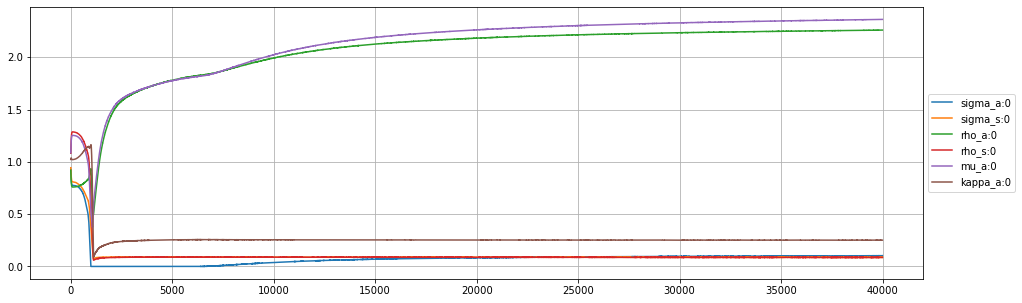

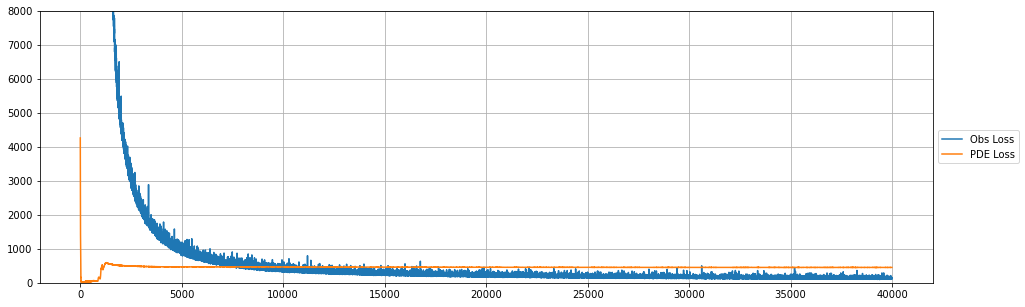

In [83]:
param_names = [v.name for v in loss_stack_1[1].trainable_vars()]
params_len = len(param_names)
W_n = len(layers)-1

start = 10

_ = plt.figure(figsize=(16,5))
#plt.subplot(2,1,1)
for j in range(params_len):
    plt.plot(samples_params_1[start:,j], label=f"{param_names[j]}")

#plt.ylim([0,.28])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#plt.subplot(2,1,2)
fig = plt.figure(figsize=(16,5))
fig.patch.set_facecolor('white')
plt.plot(arr_losses_1[start:,0], label="Obs Loss")
plt.plot(arr_losses_1[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([0,8000])

plt.show()

In [12]:
print_model(model_1)

sigma_s: 0.01731037, actual: 0.020, difference: 0.00268963, relative: %13.44812512
rho_s: 0.01729331, actual: 0.020, difference: 0.00270669, relative: %13.53345662

sigma_a: 0.00051420, actual: 0.000, difference: 0.00051420 
rho_a: 0.01129848, actual: 0.010, difference: 0.00129848, relative: %12.98484802
mu_a: 0.01180905, actual: 0.010, difference: 0.00180905, relative: %18.09054613
kappa_a: 0.25145340, actual: 0.250, difference: 0.00145340, relative: %0.58135986


In [13]:
arr_losses_2, samples_params_2, _ = \
         model_1.train(10000,
                       batch_size=dataset['obs_input'].shape[0]//8, 
                       print_iter=100,
                       stop_threshold = 1.0,
                       regularised=False,
                       regularisation_freq=10,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:562.77
Loss_observations:110.34536266 
Loss_ASDM:452.42637253 sigma_a:0:0.10250074, sigma_s:0:0.08736419, rho_a:0:2.25951219, rho_s:0:0.08599441, mu_a:0:2.36201978, kappa_a:0:0.25167337
Time:0.74

Epoch: 100, loss:584.85
Loss_observations:132.09765434 
Loss_ASDM:452.75412750 sigma_a:0:0.10312746, sigma_s:0:0.08690070, rho_a:0:2.26023912, rho_s:0:0.08632288, mu_a:0:2.36175728, kappa_a:0:0.25123623
Time:79.57

Epoch: 200, loss:614.67
Loss_observations:161.33046532 
Loss_ASDM:453.34195328 sigma_a:0:0.10317472, sigma_s:0:0.08728949, rho_a:0:2.26014185, rho_s:0:0.08584981, mu_a:0:2.36223269, kappa_a:0:0.25151476
Time:80.73

Epoch: 300, loss:578.90
Loss_observations:125.68382645 
Loss_ASDM:453.21219254 sigma_a:0:0.10238751, sigma_s:0:0.08699106, rho_a:0:2.26016235, rho_s:0:0.08657208, mu_a:0:2.36296487, kappa_a:0:0.25156370
Time:81.37

Epoch: 400, loss:572.87
Loss_observations:119.25223923 
Loss_ASDM:453.61363220 sigma_a:0:0.10335911, sigma_s:0:0.08732578, rho_a:0:2.26072383, 

Epoch: 3800, loss:566.53
Loss_observations:113.81132889 
Loss_ASDM:452.72221375 sigma_a:0:0.10443389, sigma_s:0:0.08654237, rho_a:0:2.26766872, rho_s:0:0.08639008, mu_a:0:2.37230968, kappa_a:0:0.25145867
Time:85.61

Epoch: 3900, loss:577.27
Loss_observations:123.93731308 
Loss_ASDM:453.33534622 sigma_a:0:0.10500330, sigma_s:0:0.08629525, rho_a:0:2.26810455, rho_s:0:0.08621702, mu_a:0:2.37223554, kappa_a:0:0.25163630
Time:84.40

Epoch: 4000, loss:584.83
Loss_observations:133.13673115 
Loss_ASDM:451.69443893 sigma_a:0:0.10467022, sigma_s:0:0.08723892, rho_a:0:2.26810241, rho_s:0:0.08591150, mu_a:0:2.37268710, kappa_a:0:0.25139812
Time:85.32

Epoch: 4100, loss:573.02
Loss_observations:120.07046509 
Loss_ASDM:452.95440674 sigma_a:0:0.10477707, sigma_s:0:0.08720443, rho_a:0:2.26804376, rho_s:0:0.08602752, mu_a:0:2.37313247, kappa_a:0:0.25154489
Time:83.60

Epoch: 4200, loss:563.06
Loss_observations:110.42618179 
Loss_ASDM:452.63348389 sigma_a:0:0.10552128, sigma_s:0:0.08708738, rho_a:0:2.26

Epoch: 7600, loss:566.06
Loss_observations:112.82740211 
Loss_ASDM:453.22916031 sigma_a:0:0.10607553, sigma_s:0:0.08673954, rho_a:0:2.27519417, rho_s:0:0.08635224, mu_a:0:2.38095140, kappa_a:0:0.25124231
Time:78.99

Epoch: 7700, loss:557.81
Loss_observations:105.18803024 
Loss_ASDM:452.62555695 sigma_a:0:0.10625049, sigma_s:0:0.08678833, rho_a:0:2.27508163, rho_s:0:0.08611665, mu_a:0:2.38145232, kappa_a:0:0.25156444
Time:78.67

Epoch: 7800, loss:617.62
Loss_observations:164.79798889 
Loss_ASDM:452.82342529 sigma_a:0:0.10694730, sigma_s:0:0.08676066, rho_a:0:2.27571511, rho_s:0:0.08606362, mu_a:0:2.38128519, kappa_a:0:0.25117314
Time:76.71

Epoch: 7900, loss:571.15
Loss_observations:117.52432251 
Loss_ASDM:453.62599945 sigma_a:0:0.10653608, sigma_s:0:0.08655408, rho_a:0:2.27573705, rho_s:0:0.08651459, mu_a:0:2.38175154, kappa_a:0:0.25129509
Time:79.66

Epoch: 8000, loss:621.16
Loss_observations:168.29111099 
Loss_ASDM:452.86858749 sigma_a:0:0.10663862, sigma_s:0:0.08685093, rho_a:0:2.27

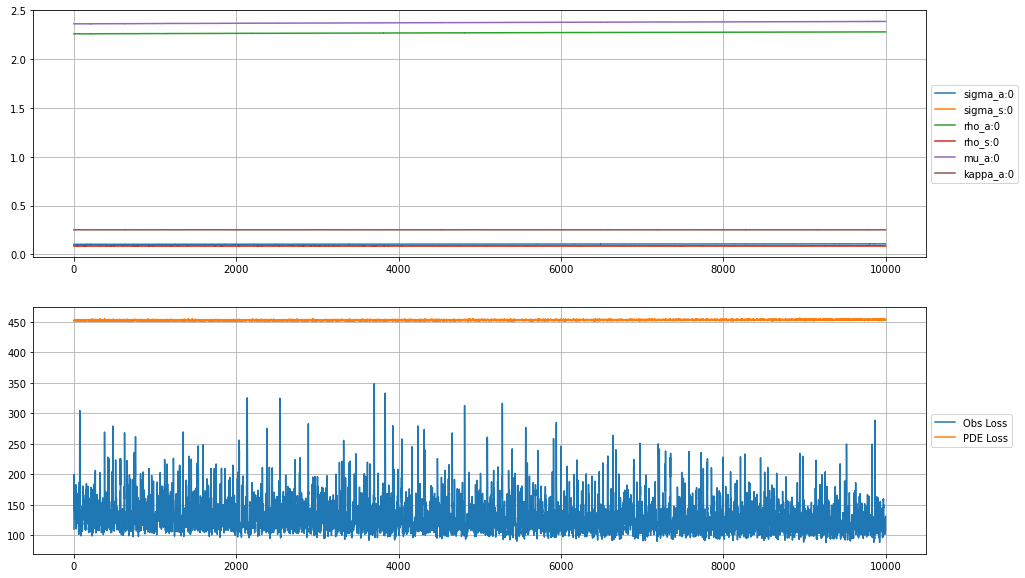

In [15]:
param_names = [v.name for v in loss_stack_1[1].trainable_vars()]
params_len = len(param_names)
W_n = len(layers)-1

start = 0

_ = plt.figure(figsize=(16,10))
plt.subplot(2,1,1)
for j in range(params_len):
    plt.plot(samples_params_2[start:,j], label=f"{param_names[j]}")

#plt.ylim([0,.28])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(2,1,2)
plt.plot(arr_losses_2[start:,0], label="Obs Loss")
plt.plot(arr_losses_2[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim([0,8000])

plt.show()

In [16]:
print_model(model_1)

sigma_s: 0.01726281, actual: 0.020, difference: 0.00273719, relative: %13.68594021
rho_s: 0.01735863, actual: 0.020, difference: 0.00264137, relative: %13.20683807

sigma_a: 0.00053744, actual: 0.000, difference: 0.00053744 
rho_a: 0.01139629, actual: 0.010, difference: 0.00139629, relative: %13.96292448
mu_a: 0.01193100, actual: 0.010, difference: 0.00193100, relative: %19.31002140
kappa_a: 0.25144121, actual: 0.250, difference: 0.00144121, relative: %0.57648420


In [17]:
arr_losses_3, samples_params_3, _ = \
         model_1.train(50000,
                       batch_size=dataset['obs_input'].shape[0]//8, 
                       print_iter=100,
                       stop_threshold = 1.0,
                       regularised=False,
                       regularisation_freq=10,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:579.13
Loss_observations:124.98017883 
Loss_ASDM:454.14888382 sigma_a:0:0.10748067, sigma_s:0:0.08745594, rho_a:0:2.27933931, rho_s:0:0.08533336, mu_a:0:2.38615108, kappa_a:0:0.25142255
Time:0.69

Epoch: 100, loss:596.03
Loss_observations:143.72282696 
Loss_ASDM:452.30924988 sigma_a:0:0.10780509, sigma_s:0:0.08717290, rho_a:0:2.27922630, rho_s:0:0.08550224, mu_a:0:2.38651323, kappa_a:0:0.25153995
Time:84.06

Epoch: 200, loss:551.78
Loss_observations:97.74523258 
Loss_ASDM:454.03718948 sigma_a:0:0.10757721, sigma_s:0:0.08627214, rho_a:0:2.27941298, rho_s:0:0.08656338, mu_a:0:2.38694406, kappa_a:0:0.25147504
Time:85.36

Epoch: 300, loss:557.60
Loss_observations:103.57558918 
Loss_ASDM:454.02005005 sigma_a:0:0.10743207, sigma_s:0:0.08730106, rho_a:0:2.27963090, rho_s:0:0.08563911, mu_a:0:2.38722587, kappa_a:0:0.25165659
Time:86.57

Epoch: 400, loss:558.26
Loss_observations:104.55438232 
Loss_ASDM:453.70172501 sigma_a:0:0.10744862, sigma_s:0:0.08700349, rho_a:0:2.28013849, r

Epoch: 3900, loss:561.77
Loss_observations:107.73083019 
Loss_ASDM:454.03992844 sigma_a:0:0.10922601, sigma_s:0:0.08711051, rho_a:0:2.28605843, rho_s:0:0.08594119, mu_a:0:2.39444566, kappa_a:0:0.25095496
Time:85.52

Epoch: 4000, loss:551.53
Loss_observations:97.85323811 
Loss_ASDM:453.67602921 sigma_a:0:0.10932992, sigma_s:0:0.08658918, rho_a:0:2.28638339, rho_s:0:0.08630485, mu_a:0:2.39439178, kappa_a:0:0.25072950
Time:86.42

Epoch: 4100, loss:562.11
Loss_observations:107.53975868 
Loss_ASDM:454.56804657 sigma_a:0:0.10888734, sigma_s:0:0.08670993, rho_a:0:2.28590417, rho_s:0:0.08623503, mu_a:0:2.39501023, kappa_a:0:0.25129807
Time:83.21

Epoch: 4200, loss:560.13
Loss_observations:106.44056225 
Loss_ASDM:453.69298172 sigma_a:0:0.10912339, sigma_s:0:0.08674149, rho_a:0:2.28609514, rho_s:0:0.08588849, mu_a:0:2.39514971, kappa_a:0:0.25139210
Time:88.52

Epoch: 4300, loss:558.07
Loss_observations:103.93649960 
Loss_ASDM:454.13169479 sigma_a:0:0.10900014, sigma_s:0:0.08731560, rho_a:0:2.286

Epoch: 7700, loss:550.90
Loss_observations:95.34787846 
Loss_ASDM:455.55491257 sigma_a:0:0.11012860, sigma_s:0:0.08694764, rho_a:0:2.29142714, rho_s:0:0.08590815, mu_a:0:2.40185761, kappa_a:0:0.25113747
Time:91.59

Epoch: 7800, loss:567.85
Loss_observations:112.89743042 
Loss_ASDM:454.95184326 sigma_a:0:0.11023597, sigma_s:0:0.08660629, rho_a:0:2.29157567, rho_s:0:0.08624715, mu_a:0:2.40198612, kappa_a:0:0.25113323
Time:86.32

Epoch: 7900, loss:552.76
Loss_observations:97.06158066 
Loss_ASDM:455.70079803 sigma_a:0:0.11039200, sigma_s:0:0.08692260, rho_a:0:2.29164767, rho_s:0:0.08587231, mu_a:0:2.40208387, kappa_a:0:0.25115284
Time:85.10

Epoch: 8000, loss:567.58
Loss_observations:112.45277023 
Loss_ASDM:455.13063049 sigma_a:0:0.11065421, sigma_s:0:0.08652963, rho_a:0:2.29223776, rho_s:0:0.08600970, mu_a:0:2.40186524, kappa_a:0:0.25098103
Time:87.13

Epoch: 8100, loss:588.90
Loss_observations:132.48835564 
Loss_ASDM:456.40878677 sigma_a:0:0.11061861, sigma_s:0:0.08730904, rho_a:0:2.2919

Epoch: 11500, loss:608.81
Loss_observations:152.82737255 
Loss_ASDM:455.97927094 sigma_a:0:0.11132761, sigma_s:0:0.08681942, rho_a:0:2.29688048, rho_s:0:0.08616807, mu_a:0:2.40808415, kappa_a:0:0.25065142
Time:82.76

Epoch: 11600, loss:564.23
Loss_observations:107.64443684 
Loss_ASDM:456.58830643 sigma_a:0:0.11120695, sigma_s:0:0.08702996, rho_a:0:2.29665232, rho_s:0:0.08581530, mu_a:0:2.40871811, kappa_a:0:0.25102657
Time:84.93

Epoch: 11700, loss:573.32
Loss_observations:117.41368866 
Loss_ASDM:455.90687943 sigma_a:0:0.11181922, sigma_s:0:0.08643327, rho_a:0:2.29707098, rho_s:0:0.08618788, mu_a:0:2.40861845, kappa_a:0:0.25090060
Time:83.62

Epoch: 11800, loss:615.43
Loss_observations:159.77651787 
Loss_ASDM:455.64914703 sigma_a:0:0.11138966, sigma_s:0:0.08692178, rho_a:0:2.29709888, rho_s:0:0.08591956, mu_a:0:2.40907025, kappa_a:0:0.25101855
Time:82.60

Epoch: 11900, loss:559.76
Loss_observations:104.19557858 
Loss_ASDM:455.56000900 sigma_a:0:0.11203527, sigma_s:0:0.08662155, rho_a:0

Epoch: 15300, loss:565.65
Loss_observations:109.53269958 
Loss_ASDM:456.11906433 sigma_a:0:0.11270975, sigma_s:0:0.08671147, rho_a:0:2.30166888, rho_s:0:0.08611548, mu_a:0:2.41517949, kappa_a:0:0.25115481
Time:92.75

Epoch: 15400, loss:542.76
Loss_observations:87.10101891 
Loss_ASDM:455.66323853 sigma_a:0:0.11294819, sigma_s:0:0.08674858, rho_a:0:2.30205965, rho_s:0:0.08598197, mu_a:0:2.41503477, kappa_a:0:0.25070614
Time:86.38

Epoch: 15500, loss:582.73
Loss_observations:127.02233982 
Loss_ASDM:455.71035385 sigma_a:0:0.11266853, sigma_s:0:0.08679183, rho_a:0:2.30215073, rho_s:0:0.08593351, mu_a:0:2.41539168, kappa_a:0:0.25108939
Time:88.79

Epoch: 15600, loss:569.25
Loss_observations:112.04433346 
Loss_ASDM:457.20967484 sigma_a:0:0.11307212, sigma_s:0:0.08611733, rho_a:0:2.30225039, rho_s:0:0.08603760, mu_a:0:2.41568017, kappa_a:0:0.25124371
Time:88.14

Epoch: 15700, loss:546.54
Loss_observations:89.44954491 
Loss_ASDM:457.08993149 sigma_a:0:0.11309829, sigma_s:0:0.08671851, rho_a:0:2

Epoch: 19100, loss:587.21
Loss_observations:129.31952190 
Loss_ASDM:457.89016342 sigma_a:0:0.11438944, sigma_s:0:0.08660263, rho_a:0:2.30688572, rho_s:0:0.08566746, mu_a:0:2.42126560, kappa_a:0:0.25081173
Time:89.74

Epoch: 19200, loss:598.48
Loss_observations:142.04478931 
Loss_ASDM:456.43563843 sigma_a:0:0.11429399, sigma_s:0:0.08711893, rho_a:0:2.30695844, rho_s:0:0.08528980, mu_a:0:2.42165494, kappa_a:0:0.25109571
Time:92.55

Epoch: 19300, loss:545.49
Loss_observations:87.90100479 
Loss_ASDM:457.59221268 sigma_a:0:0.11349782, sigma_s:0:0.08691266, rho_a:0:2.30719757, rho_s:0:0.08603795, mu_a:0:2.42212462, kappa_a:0:0.25097144
Time:88.97

Epoch: 19400, loss:545.46
Loss_observations:88.61563587 
Loss_ASDM:456.84762573 sigma_a:0:0.11407804, sigma_s:0:0.08662160, rho_a:0:2.30749297, rho_s:0:0.08596268, mu_a:0:2.42226768, kappa_a:0:0.25083274
Time:89.91

Epoch: 19500, loss:557.52
Loss_observations:99.93537235 
Loss_ASDM:457.58038330 sigma_a:0:0.11416446, sigma_s:0:0.08665386, rho_a:0:2.

Epoch: 22900, loss:640.14
Loss_observations:180.89903831 
Loss_ASDM:459.23720551 sigma_a:0:0.11508197, sigma_s:0:0.08727320, rho_a:0:2.31232238, rho_s:0:0.08525939, mu_a:0:2.42847037, kappa_a:0:0.25075892
Time:90.24

Epoch: 23000, loss:564.87
Loss_observations:105.33159733 
Loss_ASDM:459.53605270 sigma_a:0:0.11562194, sigma_s:0:0.08626701, rho_a:0:2.31278110, rho_s:0:0.08623616, mu_a:0:2.42831612, kappa_a:0:0.25072762
Time:92.46

Epoch: 23100, loss:565.72
Loss_observations:107.30125523 
Loss_ASDM:458.42369080 sigma_a:0:0.11548267, sigma_s:0:0.08654486, rho_a:0:2.31260014, rho_s:0:0.08610516, mu_a:0:2.42875171, kappa_a:0:0.25095665
Time:96.61

Epoch: 23200, loss:578.50
Loss_observations:119.81022453 
Loss_ASDM:458.69380188 sigma_a:0:0.11559912, sigma_s:0:0.08702283, rho_a:0:2.31290746, rho_s:0:0.08559917, mu_a:0:2.42878509, kappa_a:0:0.25074241
Time:92.55

Epoch: 23300, loss:541.40
Loss_observations:82.46000195 
Loss_ASDM:458.94089127 sigma_a:0:0.11519307, sigma_s:0:0.08731008, rho_a:0:

Epoch: 26700, loss:635.83
Loss_observations:176.21853447 
Loss_ASDM:459.60845184 sigma_a:0:0.11621049, sigma_s:0:0.08682812, rho_a:0:2.31796503, rho_s:0:0.08590124, mu_a:0:2.43582273, kappa_a:0:0.25071639
Time:92.35

Epoch: 26800, loss:563.07
Loss_observations:103.36062336 
Loss_ASDM:459.70712280 sigma_a:0:0.11636828, sigma_s:0:0.08692528, rho_a:0:2.31837153, rho_s:0:0.08567315, mu_a:0:2.43569541, kappa_a:0:0.25052989
Time:92.35

Epoch: 26900, loss:563.01
Loss_observations:102.25343990 
Loss_ASDM:460.75484467 sigma_a:0:0.11659619, sigma_s:0:0.08645610, rho_a:0:2.31847358, rho_s:0:0.08600264, mu_a:0:2.43570113, kappa_a:0:0.25063956
Time:96.99

Epoch: 27000, loss:573.94
Loss_observations:113.53788185 
Loss_ASDM:460.40644455 sigma_a:0:0.11647426, sigma_s:0:0.08685720, rho_a:0:2.31851554, rho_s:0:0.08567813, mu_a:0:2.43603587, kappa_a:0:0.25087887
Time:89.48

Epoch: 27100, loss:558.29
Loss_observations:98.51454163 
Loss_ASDM:459.77531815 sigma_a:0:0.11729963, sigma_s:0:0.08612788, rho_a:0:

Epoch: 30500, loss:553.49
Loss_observations:92.79531860 
Loss_ASDM:460.69944382 sigma_a:0:0.11747476, sigma_s:0:0.08651487, rho_a:0:2.32369995, rho_s:0:0.08603010, mu_a:0:2.44275451, kappa_a:0:0.25076884
Time:91.75

Epoch: 30600, loss:609.05
Loss_observations:147.02989006 
Loss_ASDM:462.01937866 sigma_a:0:0.11800934, sigma_s:0:0.08609705, rho_a:0:2.32431626, rho_s:0:0.08622055, mu_a:0:2.44251084, kappa_a:0:0.25047797
Time:95.47

Epoch: 30700, loss:552.43
Loss_observations:91.09243679 
Loss_ASDM:461.34245682 sigma_a:0:0.11802480, sigma_s:0:0.08663282, rho_a:0:2.32416964, rho_s:0:0.08537096, mu_a:0:2.44293213, kappa_a:0:0.25073528
Time:93.28

Epoch: 30800, loss:578.91
Loss_observations:117.69243813 
Loss_ASDM:461.21875381 sigma_a:0:0.11773839, sigma_s:0:0.08684375, rho_a:0:2.32417393, rho_s:0:0.08566000, mu_a:0:2.44331431, kappa_a:0:0.25079599
Time:90.99

Epoch: 30900, loss:545.08
Loss_observations:84.10181141 
Loss_ASDM:460.98042679 sigma_a:0:0.11800572, sigma_s:0:0.08676692, rho_a:0:2.

Epoch: 34300, loss:564.64
Loss_observations:101.65262985 
Loss_ASDM:462.98979568 sigma_a:0:0.11900411, sigma_s:0:0.08632578, rho_a:0:2.33015752, rho_s:0:0.08616573, mu_a:0:2.45030046, kappa_a:0:0.25050902
Time:97.92

Epoch: 34400, loss:553.98
Loss_observations:90.33343601 
Loss_ASDM:463.64984894 sigma_a:0:0.11916535, sigma_s:0:0.08688612, rho_a:0:2.33040833, rho_s:0:0.08565269, mu_a:0:2.45046854, kappa_a:0:0.25038013
Time:91.06

Epoch: 34500, loss:537.74
Loss_observations:75.34675312 
Loss_ASDM:462.39472580 sigma_a:0:0.11901093, sigma_s:0:0.08668036, rho_a:0:2.33050847, rho_s:0:0.08592380, mu_a:0:2.45089746, kappa_a:0:0.25044367
Time:96.78

Epoch: 34600, loss:562.85
Loss_observations:100.23361492 
Loss_ASDM:462.61755753 sigma_a:0:0.11839625, sigma_s:0:0.08732829, rho_a:0:2.33057022, rho_s:0:0.08560929, mu_a:0:2.45135379, kappa_a:0:0.25060382
Time:88.41

Epoch: 34700, loss:571.88
Loss_observations:109.22111034 
Loss_ASDM:462.65989685 sigma_a:0:0.11926284, sigma_s:0:0.08665538, rho_a:0:2

Epoch: 38100, loss:563.32
Loss_observations:98.62613392 
Loss_ASDM:464.69683838 sigma_a:0:0.12081603, sigma_s:0:0.08665963, rho_a:0:2.33639598, rho_s:0:0.08570036, mu_a:0:2.45753098, kappa_a:0:0.25022468
Time:97.47

Epoch: 38200, loss:542.48
Loss_observations:77.78844452 
Loss_ASDM:464.69275665 sigma_a:0:0.12040912, sigma_s:0:0.08672095, rho_a:0:2.33603001, rho_s:0:0.08540799, mu_a:0:2.45832872, kappa_a:0:0.25082192
Time:92.26

Epoch: 38300, loss:557.99
Loss_observations:92.68701935 
Loss_ASDM:465.30021667 sigma_a:0:0.12100833, sigma_s:0:0.08630273, rho_a:0:2.33663273, rho_s:0:0.08562794, mu_a:0:2.45797682, kappa_a:0:0.25041619
Time:91.78

Epoch: 38400, loss:564.21
Loss_observations:98.84845161 
Loss_ASDM:465.36415863 sigma_a:0:0.12050287, sigma_s:0:0.08661269, rho_a:0:2.33643675, rho_s:0:0.08570990, mu_a:0:2.45857239, kappa_a:0:0.25045916
Time:97.76

Epoch: 38500, loss:550.54
Loss_observations:84.01465893 
Loss_ASDM:466.52062225 sigma_a:0:0.12025601, sigma_s:0:0.08718749, rho_a:0:2.33

Epoch: 41900, loss:555.32
Loss_observations:88.12658119 
Loss_ASDM:467.19529724 sigma_a:0:0.12225512, sigma_s:0:0.08602720, rho_a:0:2.34251595, rho_s:0:0.08591335, mu_a:0:2.46559381, kappa_a:0:0.25050217
Time:91.04

Epoch: 42000, loss:560.42
Loss_observations:94.42317200 
Loss_ASDM:466.00016785 sigma_a:0:0.12188502, sigma_s:0:0.08658528, rho_a:0:2.34278893, rho_s:0:0.08546710, mu_a:0:2.46574640, kappa_a:0:0.25035474
Time:90.89

Epoch: 42100, loss:564.13
Loss_observations:96.33228588 
Loss_ASDM:467.80254745 sigma_a:0:0.12150138, sigma_s:0:0.08680224, rho_a:0:2.34246302, rho_s:0:0.08557527, mu_a:0:2.46646261, kappa_a:0:0.25075567
Time:91.14

Epoch: 42200, loss:579.85
Loss_observations:112.35511971 
Loss_ASDM:467.49761200 sigma_a:0:0.12183875, sigma_s:0:0.08680612, rho_a:0:2.34292126, rho_s:0:0.08543176, mu_a:0:2.46630478, kappa_a:0:0.25046924
Time:88.89

Epoch: 42300, loss:543.72
Loss_observations:77.15701675 
Loss_ASDM:466.56108856 sigma_a:0:0.12193996, sigma_s:0:0.08622232, rho_a:0:2.3

Epoch: 45700, loss:561.50
Loss_observations:92.37522030 
Loss_ASDM:469.12075424 sigma_a:0:0.12308229, sigma_s:0:0.08625252, rho_a:0:2.34864879, rho_s:0:0.08587368, mu_a:0:2.47409296, kappa_a:0:0.25061345
Time:99.75

Epoch: 45800, loss:553.96
Loss_observations:83.86517429 
Loss_ASDM:470.09713364 sigma_a:0:0.12298422, sigma_s:0:0.08686142, rho_a:0:2.34905958, rho_s:0:0.08579563, mu_a:0:2.47422528, kappa_a:0:0.25039205
Time:90.57

Epoch: 45900, loss:559.39
Loss_observations:89.19056511 
Loss_ASDM:470.20421600 sigma_a:0:0.12296443, sigma_s:0:0.08682003, rho_a:0:2.34936523, rho_s:0:0.08572300, mu_a:0:2.47428823, kappa_a:0:0.25022602
Time:91.63

Epoch: 46000, loss:576.65
Loss_observations:106.92840385 
Loss_ASDM:469.71893311 sigma_a:0:0.12291144, sigma_s:0:0.08651668, rho_a:0:2.34966445, rho_s:0:0.08602539, mu_a:0:2.47456050, kappa_a:0:0.25025624
Time:88.44

Epoch: 46100, loss:580.04
Loss_observations:109.62276840 
Loss_ASDM:470.42032242 sigma_a:0:0.12342402, sigma_s:0:0.08681924, rho_a:0:2.

Epoch: 49500, loss:557.65
Loss_observations:84.50807190 
Loss_ASDM:473.14572525 sigma_a:0:0.12486096, sigma_s:0:0.08625697, rho_a:0:2.35635567, rho_s:0:0.08588479, mu_a:0:2.48292208, kappa_a:0:0.25011373
Time:94.08

Epoch: 49600, loss:558.93
Loss_observations:85.51499653 
Loss_ASDM:473.41408920 sigma_a:0:0.12462670, sigma_s:0:0.08690254, rho_a:0:2.35639429, rho_s:0:0.08558943, mu_a:0:2.48337221, kappa_a:0:0.25028962
Time:88.61

Epoch: 49700, loss:574.05
Loss_observations:100.72986221 
Loss_ASDM:473.32423019 sigma_a:0:0.12484061, sigma_s:0:0.08638562, rho_a:0:2.35654736, rho_s:0:0.08604425, mu_a:0:2.48360085, kappa_a:0:0.25035331
Time:93.55

Epoch: 49800, loss:573.40
Loss_observations:99.79206467 
Loss_ASDM:473.60336304 sigma_a:0:0.12482333, sigma_s:0:0.08652166, rho_a:0:2.35683227, rho_s:0:0.08575128, mu_a:0:2.48381805, kappa_a:0:0.25026277
Time:101.66

Epoch: 49900, loss:561.88
Loss_observations:88.20494938 
Loss_ASDM:473.67163086 sigma_a:0:0.12502894, sigma_s:0:0.08614358, rho_a:0:2.

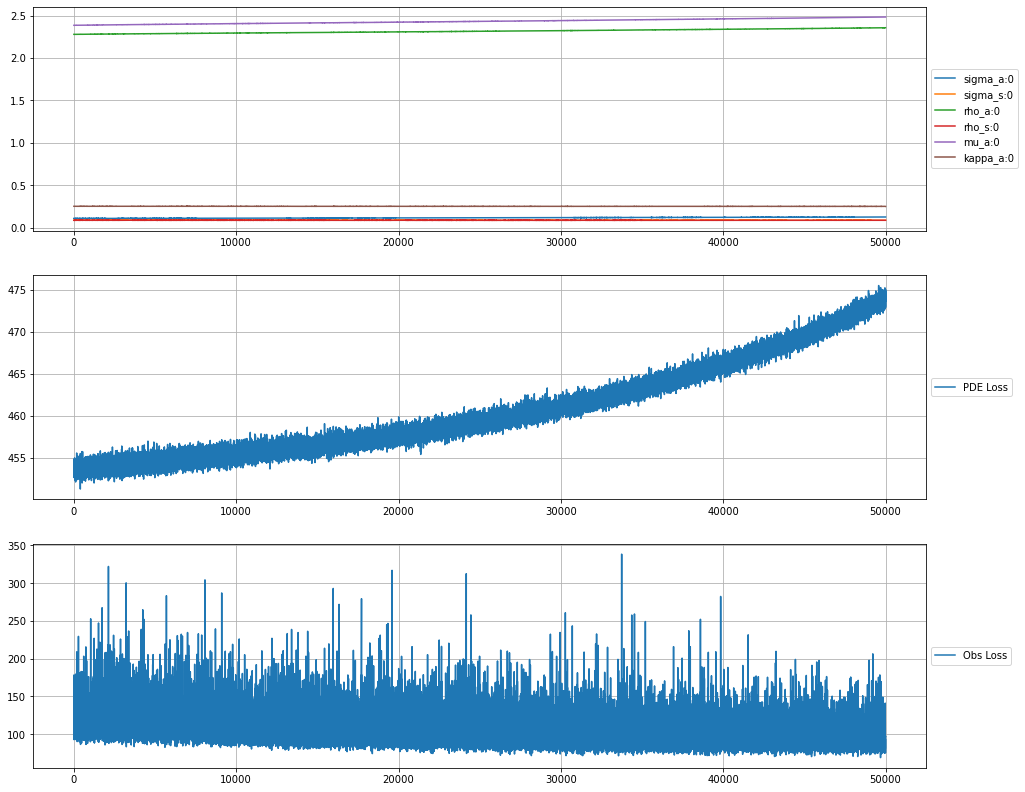

In [24]:
param_names = [v.name for v in loss_stack_1[1].trainable_vars()]
params_len = len(param_names)
W_n = len(layers)-1

start = 0

_ = plt.figure(figsize=(16,14))
plt.subplot(3,1,1)
for j in range(params_len):
    plt.plot(samples_params_3[start:,j], label=f"{param_names[j]}")

#plt.ylim([0,.28])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(3,1,2)
#plt.plot(arr_losses_3[start:,0], label="Obs Loss")
plt.plot(arr_losses_3[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim([0,8000])



plt.subplot(3,1,3)
plt.plot(arr_losses_3[start:,0], label="Obs Loss")
#plt.plot(arr_losses_3[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim([0,8000])

plt.show()

In [25]:
arr_losses_4, samples_params_4, samples_grads_4 = \
         model_1.train(100,
                       batch_size=dataset['obs_input'].shape[0]//8, 
                       print_iter=100,
                       stop_threshold = 1.0,
                       regularised=False,
                       regularisation_freq=10,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=True)

Epoch: 1, loss:580.09
Loss_observations:110.41593266 
Loss_ASDM:469.67833328 sigma_a:0:0.12500508, sigma_s:0:0.08656918, rho_a:0:2.35703850, rho_s:0:0.08545715, mu_a:0:2.48446798, kappa_a:0:0.25060773
Time:5.70

Epoch: 100, loss:529.38
Loss_observations:96.74858952 
Loss_ASDM:432.62744522 sigma_a:0:0.12928772, sigma_s:0:0.08571427, rho_a:0:2.34015083, rho_s:0:0.08544401, mu_a:0:2.47422528, kappa_a:0:0.24886796
Time:177.54



In [27]:
param_names = [v.name for v in loss_stack_1[1].trainable_vars()]
params_len = len(param_names)
W_n = len(layers)-1

def find_grads(samples_grads):
    
    total_g_per_losses = np.sum(samples_grads, axis=2)
    total_g = np.sum(total_g_per_losses, axis = 1)
    # The first is matrix W_i and the second vector is b_i
    pinn_g_per_layer_per_losses = np.array([[ samples_grads[:, l, i] + samples_grads[:, l, i+W_n] 
                                              for i in range(W_n)]
                                              for l in range(samples_grads.shape[1])
                                          ])
    
    pinn_g_per_layer_ratios = np.array([[pinn_g_per_layer_per_losses[ l, i, :]/total_g
                                              for i in range(W_n)]
                                              for l in range(samples_grads.shape[1])
                                       ])
    
    params_g_per_losses = np.array([[ samples_grads[:, l, i + 2*W_n ] 
                                              for i in range(params_len)]
                                              for l in range(samples_grads.shape[1])
                                          ])
    
    params_g_ratios = np.array([[ params_g_per_losses[l, i, :]/total_g 
                                              for i in range(params_len)]
                                              for l in range(samples_grads.shape[1])
                                          ])
    
    return (total_g,
            total_g_per_losses, 
            pinn_g_per_layer_per_losses, 
            pinn_g_per_layer_ratios,
            params_g_per_losses,
            params_g_ratios)

(total_g_4, 
 total_g_4_per_losses,
 pinn_g_4_per_layer_per_losses, 
 pinn_g_4_per_layer_ratios,
 params_g_4_per_losses, 
 params_g_4_ratios) = find_grads(samples_grads_4) 

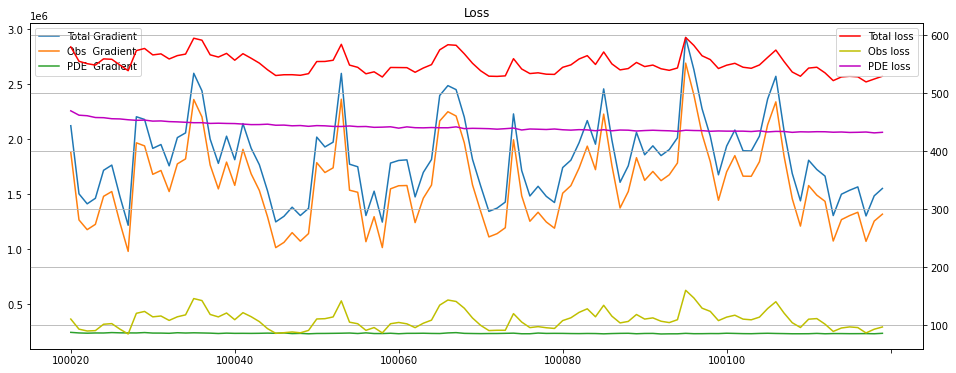

In [36]:
start = 0
_ = plt.figure(figsize=(16,6))

ax1 = plt.gca()
ax2 = ax1.twinx()

plt.title("Loss")
ax1.plot(total_g_4[start:], label="Total Gradient")
ax1.plot(total_g_4_per_losses[start:,0], label="Obs  Gradient")
ax1.plot(total_g_4_per_losses[start:,1], label="PDE  Gradient")
ax1.legend(loc='upper left')
ax1.set_xticklabels([100000, 100020, 100040, 100060, 100080, 100100])

ax2.plot(np.sum(arr_losses_4, axis=1)[start:], c='r', label="Total loss")
ax2.plot(arr_losses_4[start:,0], c='y', label="Obs loss")
ax2.plot(arr_losses_4[start:,1], c='m', label="PDE loss")
ax2.legend(loc='upper right')
#ax2.set_yscale('log')


plt.grid()
plt.show()


In [37]:
arr_losses_5, samples_params_5, _ = \
         model_1.train(50000,
                       batch_size=dataset['obs_input'].shape[0]//8, 
                       print_iter=100,
                       stop_threshold = 1.0,
                       regularised=False,
                       regularisation_freq=10,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:532.80
Loss_observations:97.14348030 
Loss_ASDM:435.66141510 sigma_a:0:0.12910359, sigma_s:0:0.08647031, rho_a:0:2.33979201, rho_s:0:0.08463451, mu_a:0:2.47426105, kappa_a:0:0.24925366
Time:0.61

Epoch: 100, loss:555.50
Loss_observations:97.27310371 
Loss_ASDM:458.22838974 sigma_a:0:0.12218536, sigma_s:0:0.08662049, rho_a:0:2.33951640, rho_s:0:0.08550441, mu_a:0:2.46430945, kappa_a:0:0.25034174
Time:78.31

Epoch: 200, loss:554.41
Loss_observations:93.16517353 
Loss_ASDM:461.24143982 sigma_a:0:0.12158127, sigma_s:0:0.08694089, rho_a:0:2.33906126, rho_s:0:0.08544184, mu_a:0:2.46277404, kappa_a:0:0.25012344
Time:76.30

Epoch: 300, loss:555.14
Loss_observations:91.36099625 
Loss_ASDM:463.78383255 sigma_a:0:0.12160582, sigma_s:0:0.08678499, rho_a:0:2.33907533, rho_s:0:0.08537975, mu_a:0:2.46311688, kappa_a:0:0.25051740
Time:74.05

Epoch: 400, loss:546.00
Loss_observations:80.68110371 
Loss_ASDM:465.31456375 sigma_a:0:0.12109219, sigma_s:0:0.08644511, rho_a:0:2.33979106, rho_s

Epoch: 3900, loss:558.12
Loss_observations:82.94850445 
Loss_ASDM:475.16682434 sigma_a:0:0.12615909, sigma_s:0:0.08610188, rho_a:0:2.36135483, rho_s:0:0.08556851, mu_a:0:2.49005842, kappa_a:0:0.25028193
Time:81.90

Epoch: 4000, loss:571.96
Loss_observations:97.63518906 
Loss_ASDM:474.32016754 sigma_a:0:0.12648667, sigma_s:0:0.08632281, rho_a:0:2.36176968, rho_s:0:0.08525273, mu_a:0:2.49052262, kappa_a:0:0.25019982
Time:77.78

Epoch: 4100, loss:559.07
Loss_observations:85.23854065 
Loss_ASDM:473.83033371 sigma_a:0:0.12637934, sigma_s:0:0.08681317, rho_a:0:2.36228013, rho_s:0:0.08552653, mu_a:0:2.49072313, kappa_a:0:0.24994665
Time:76.75

Epoch: 4200, loss:580.82
Loss_observations:104.88106060 
Loss_ASDM:475.94168472 sigma_a:0:0.12621640, sigma_s:0:0.08622748, rho_a:0:2.36255336, rho_s:0:0.08591888, mu_a:0:2.49133134, kappa_a:0:0.24996227
Time:77.04

Epoch: 4300, loss:568.26
Loss_observations:93.44812202 
Loss_ASDM:474.81633377 sigma_a:0:0.12633987, sigma_s:0:0.08603723, rho_a:0:2.362906

Epoch: 7800, loss:591.78
Loss_observations:110.89753819 
Loss_ASDM:480.88196182 sigma_a:0:0.12809716, sigma_s:0:0.08685969, rho_a:0:2.37292576, rho_s:0:0.08557050, mu_a:0:2.50541615, kappa_a:0:0.25000924
Time:81.24

Epoch: 7900, loss:559.37
Loss_observations:78.61491013 
Loss_ASDM:480.75455093 sigma_a:0:0.12814352, sigma_s:0:0.08673284, rho_a:0:2.37323642, rho_s:0:0.08554077, mu_a:0:2.50588346, kappa_a:0:0.25023654
Time:78.27

Epoch: 8000, loss:567.42
Loss_observations:86.24770355 
Loss_ASDM:481.17113876 sigma_a:0:0.12854411, sigma_s:0:0.08670143, rho_a:0:2.37383032, rho_s:0:0.08548006, mu_a:0:2.50597119, kappa_a:0:0.25007209
Time:79.39

Epoch: 8100, loss:563.17
Loss_observations:81.92627430 
Loss_ASDM:481.24180603 sigma_a:0:0.12879163, sigma_s:0:0.08609927, rho_a:0:2.37434816, rho_s:0:0.08604706, mu_a:0:2.50611901, kappa_a:0:0.24971260
Time:78.66

Epoch: 8200, loss:560.65
Loss_observations:79.34546185 
Loss_ASDM:481.30109406 sigma_a:0:0.12832658, sigma_s:0:0.08632265, rho_a:0:2.374448

Epoch: 11700, loss:587.03
Loss_observations:98.23767471 
Loss_ASDM:488.78995514 sigma_a:0:0.13166611, sigma_s:0:0.08600684, rho_a:0:2.38642359, rho_s:0:0.08583786, mu_a:0:2.52087069, kappa_a:0:0.24956945
Time:85.55

Epoch: 11800, loss:585.59
Loss_observations:96.27323818 
Loss_ASDM:489.31755066 sigma_a:0:0.13139300, sigma_s:0:0.08665480, rho_a:0:2.38664007, rho_s:0:0.08541315, mu_a:0:2.52134895, kappa_a:0:0.24954899
Time:78.73

Epoch: 11900, loss:574.38
Loss_observations:84.47802448 
Loss_ASDM:489.90690231 sigma_a:0:0.13166456, sigma_s:0:0.08635916, rho_a:0:2.38680649, rho_s:0:0.08555020, mu_a:0:2.52184200, kappa_a:0:0.24994497
Time:80.92

Epoch: 12000, loss:624.14
Loss_observations:132.81504440 
Loss_ASDM:491.32635117 sigma_a:0:0.13158415, sigma_s:0:0.08658577, rho_a:0:2.38722110, rho_s:0:0.08523785, mu_a:0:2.52219439, kappa_a:0:0.24963102
Time:82.54

Epoch: 12100, loss:576.85
Loss_observations:87.27339554 
Loss_ASDM:489.57975006 sigma_a:0:0.13187869, sigma_s:0:0.08657641, rho_a:0:2.3

Epoch: 15500, loss:604.65
Loss_observations:107.36392498 
Loss_ASDM:497.28908157 sigma_a:0:0.13415228, sigma_s:0:0.08647495, rho_a:0:2.40013480, rho_s:0:0.08567311, mu_a:0:2.53803182, kappa_a:0:0.24977130
Time:77.64

Epoch: 15600, loss:601.14
Loss_observations:102.12382793 
Loss_ASDM:499.01222229 sigma_a:0:0.13418773, sigma_s:0:0.08654325, rho_a:0:2.40024209, rho_s:0:0.08560608, mu_a:0:2.53866386, kappa_a:0:0.24980997
Time:78.03

Epoch: 15700, loss:581.60
Loss_observations:81.96821690 
Loss_ASDM:499.62770462 sigma_a:0:0.13390940, sigma_s:0:0.08666837, rho_a:0:2.40056086, rho_s:0:0.08551180, mu_a:0:2.53927231, kappa_a:0:0.25006369
Time:83.58

Epoch: 15800, loss:582.71
Loss_observations:83.43128967 
Loss_ASDM:499.27700806 sigma_a:0:0.13439460, sigma_s:0:0.08662730, rho_a:0:2.40139198, rho_s:0:0.08565872, mu_a:0:2.53949976, kappa_a:0:0.24951531
Time:86.29

Epoch: 15900, loss:590.90
Loss_observations:90.53775692 
Loss_ASDM:500.36473465 sigma_a:0:0.13449609, sigma_s:0:0.08592880, rho_a:0:2.

Epoch: 19300, loss:606.14
Loss_observations:96.10175133 
Loss_ASDM:510.03348160 sigma_a:0:0.13701104, sigma_s:0:0.08659598, rho_a:0:2.41522908, rho_s:0:0.08583923, mu_a:0:2.55617523, kappa_a:0:0.24938478
Time:84.99

Epoch: 19400, loss:597.37
Loss_observations:88.07919025 
Loss_ASDM:509.29520416 sigma_a:0:0.13662601, sigma_s:0:0.08705011, rho_a:0:2.41538405, rho_s:0:0.08567940, mu_a:0:2.55698776, kappa_a:0:0.24957682
Time:80.06

Epoch: 19500, loss:592.93
Loss_observations:82.18075657 
Loss_ASDM:510.74502563 sigma_a:0:0.13683064, sigma_s:0:0.08704176, rho_a:0:2.41592050, rho_s:0:0.08568559, mu_a:0:2.55731583, kappa_a:0:0.24936368
Time:82.91

Epoch: 19600, loss:597.07
Loss_observations:85.47113132 
Loss_ASDM:511.60287476 sigma_a:0:0.13772368, sigma_s:0:0.08623108, rho_a:0:2.41651559, rho_s:0:0.08592434, mu_a:0:2.55745625, kappa_a:0:0.24941133
Time:79.20

Epoch: 19700, loss:607.80
Loss_observations:97.06945801 
Loss_ASDM:510.72996902 sigma_a:0:0.13739538, sigma_s:0:0.08642336, rho_a:0:2.41

Epoch: 23100, loss:639.36
Loss_observations:118.68355083 
Loss_ASDM:520.68045044 sigma_a:0:0.13970333, sigma_s:0:0.08615681, rho_a:0:2.42953324, rho_s:0:0.08647101, mu_a:0:2.57266927, kappa_a:0:0.24931765
Time:93.03

Epoch: 23200, loss:609.34
Loss_observations:87.70628166 
Loss_ASDM:521.63646698 sigma_a:0:0.13981143, sigma_s:0:0.08659559, rho_a:0:2.42922688, rho_s:0:0.08531082, mu_a:0:2.57355857, kappa_a:0:0.24981344
Time:94.01

Epoch: 23300, loss:613.36
Loss_observations:91.82196236 
Loss_ASDM:521.53886795 sigma_a:0:0.13948858, sigma_s:0:0.08673677, rho_a:0:2.42986608, rho_s:0:0.08586947, mu_a:0:2.57389450, kappa_a:0:0.24953075
Time:94.43

Epoch: 23400, loss:612.56
Loss_observations:90.26764774 
Loss_ASDM:522.29313278 sigma_a:0:0.13946421, sigma_s:0:0.08669674, rho_a:0:2.43013644, rho_s:0:0.08580925, mu_a:0:2.57450581, kappa_a:0:0.24972299
Time:84.75

Epoch: 23500, loss:628.93
Loss_observations:107.59716702 
Loss_ASDM:521.33470154 sigma_a:0:0.13976328, sigma_s:0:0.08700414, rho_a:0:2.

Epoch: 26900, loss:614.58
Loss_observations:82.83510208 
Loss_ASDM:531.74498749 sigma_a:0:0.14241903, sigma_s:0:0.08636614, rho_a:0:2.44277811, rho_s:0:0.08587892, mu_a:0:2.58855057, kappa_a:0:0.24967130
Time:91.13

Epoch: 27000, loss:611.44
Loss_observations:80.82791424 
Loss_ASDM:530.61138535 sigma_a:0:0.14229938, sigma_s:0:0.08670525, rho_a:0:2.44278812, rho_s:0:0.08550448, mu_a:0:2.58934617, kappa_a:0:0.24991663
Time:88.06

Epoch: 27100, loss:630.61
Loss_observations:98.92396450 
Loss_ASDM:531.68498230 sigma_a:0:0.14200529, sigma_s:0:0.08640548, rho_a:0:2.44313908, rho_s:0:0.08610478, mu_a:0:2.58981919, kappa_a:0:0.24979931
Time:87.54

Epoch: 27200, loss:623.20
Loss_observations:90.95482159 
Loss_ASDM:532.24359512 sigma_a:0:0.14196415, sigma_s:0:0.08687207, rho_a:0:2.44343328, rho_s:0:0.08557089, mu_a:0:2.59029508, kappa_a:0:0.24995461
Time:94.26

Epoch: 27300, loss:648.35
Loss_observations:114.50966644 
Loss_ASDM:533.84009933 sigma_a:0:0.14259027, sigma_s:0:0.08714463, rho_a:0:2.4

Epoch: 30700, loss:635.49
Loss_observations:95.86503887 
Loss_ASDM:539.62450790 sigma_a:0:0.14403841, sigma_s:0:0.08690481, rho_a:0:2.45478654, rho_s:0:0.08561117, mu_a:0:2.60367107, kappa_a:0:0.24972603
Time:83.99

Epoch: 30800, loss:651.62
Loss_observations:110.75151157 
Loss_ASDM:540.86885834 sigma_a:0:0.14419508, sigma_s:0:0.08679122, rho_a:0:2.45506048, rho_s:0:0.08568282, mu_a:0:2.60412145, kappa_a:0:0.24991858
Time:80.15

Epoch: 30900, loss:630.14
Loss_observations:89.81310177 
Loss_ASDM:540.32593155 sigma_a:0:0.14481993, sigma_s:0:0.08614937, rho_a:0:2.45532537, rho_s:0:0.08587513, mu_a:0:2.60420036, kappa_a:0:0.25002626
Time:80.50

Epoch: 31000, loss:651.51
Loss_observations:111.02597427 
Loss_ASDM:540.48344421 sigma_a:0:0.14463668, sigma_s:0:0.08648198, rho_a:0:2.45544600, rho_s:0:0.08570762, mu_a:0:2.60452843, kappa_a:0:0.24989954
Time:80.03

Epoch: 31100, loss:631.94
Loss_observations:90.79247475 
Loss_ASDM:541.14604950 sigma_a:0:0.14507200, sigma_s:0:0.08643421, rho_a:0:2.

Epoch: 34500, loss:640.26
Loss_observations:92.83993816 
Loss_ASDM:547.42436981 sigma_a:0:0.14646183, sigma_s:0:0.08665004, rho_a:0:2.46648622, rho_s:0:0.08569677, mu_a:0:2.61809540, kappa_a:0:0.25010580
Time:80.12

Epoch: 34600, loss:648.95
Loss_observations:101.44858360 
Loss_ASDM:547.50165939 sigma_a:0:0.14661486, sigma_s:0:0.08681644, rho_a:0:2.46688604, rho_s:0:0.08582818, mu_a:0:2.61836338, kappa_a:0:0.24976088
Time:80.98

Epoch: 34700, loss:650.53
Loss_observations:103.50281906 
Loss_ASDM:547.02976227 sigma_a:0:0.14662242, sigma_s:0:0.08682111, rho_a:0:2.46702218, rho_s:0:0.08562209, mu_a:0:2.61893058, kappa_a:0:0.24989609
Time:79.74

Epoch: 34800, loss:643.53
Loss_observations:96.95724773 
Loss_ASDM:546.57757950 sigma_a:0:0.14665805, sigma_s:0:0.08669812, rho_a:0:2.46725774, rho_s:0:0.08539035, mu_a:0:2.61938119, kappa_a:0:0.25002703
Time:78.11

Epoch: 34900, loss:645.18
Loss_observations:96.70327854 
Loss_ASDM:548.47833252 sigma_a:0:0.14625789, sigma_s:0:0.08704358, rho_a:0:2.

Epoch: 38300, loss:663.77
Loss_observations:109.25811291 
Loss_ASDM:554.50800323 sigma_a:0:0.14899714, sigma_s:0:0.08657777, rho_a:0:2.47881436, rho_s:0:0.08556084, mu_a:0:2.63300729, kappa_a:0:0.24978247
Time:80.08

Epoch: 38400, loss:670.89
Loss_observations:117.87270546 
Loss_ASDM:553.01274872 sigma_a:0:0.14901377, sigma_s:0:0.08643662, rho_a:0:2.47919416, rho_s:0:0.08574635, mu_a:0:2.63322282, kappa_a:0:0.24968861
Time:81.64

Epoch: 38500, loss:653.53
Loss_observations:99.39389420 
Loss_ASDM:554.13946533 sigma_a:0:0.14969410, sigma_s:0:0.08646460, rho_a:0:2.47917509, rho_s:0:0.08509812, mu_a:0:2.63370275, kappa_a:0:0.25015175
Time:80.17

Epoch: 38600, loss:647.77
Loss_observations:93.84887695 
Loss_ASDM:553.92462540 sigma_a:0:0.14911783, sigma_s:0:0.08657379, rho_a:0:2.47976208, rho_s:0:0.08585445, mu_a:0:2.63408256, kappa_a:0:0.24979085
Time:79.86

Epoch: 38700, loss:652.02
Loss_observations:97.14507866 
Loss_ASDM:554.87152481 sigma_a:0:0.14933251, sigma_s:0:0.08606432, rho_a:0:2.

Epoch: 42100, loss:655.69
Loss_observations:97.22010422 
Loss_ASDM:558.47391510 sigma_a:0:0.15144821, sigma_s:0:0.08633050, rho_a:0:2.49200439, rho_s:0:0.08572185, mu_a:0:2.64886618, kappa_a:0:0.24966781
Time:82.14

Epoch: 42200, loss:643.61
Loss_observations:83.48841095 
Loss_ASDM:560.11912537 sigma_a:0:0.15170702, sigma_s:0:0.08606236, rho_a:0:2.49248910, rho_s:0:0.08610949, mu_a:0:2.64918017, kappa_a:0:0.24964008
Time:79.84

Epoch: 42300, loss:656.98
Loss_observations:97.12692928 
Loss_ASDM:559.85641479 sigma_a:0:0.15162989, sigma_s:0:0.08660388, rho_a:0:2.49270391, rho_s:0:0.08550254, mu_a:0:2.64971662, kappa_a:0:0.24973151
Time:80.49

Epoch: 42400, loss:678.70
Loss_observations:118.91057396 
Loss_ASDM:559.78989792 sigma_a:0:0.15168868, sigma_s:0:0.08634068, rho_a:0:2.49296284, rho_s:0:0.08550414, mu_a:0:2.65033340, kappa_a:0:0.24976791
Time:82.18

Epoch: 42500, loss:652.26
Loss_observations:91.85229397 
Loss_ASDM:560.40423584 sigma_a:0:0.15194023, sigma_s:0:0.08635248, rho_a:0:2.4

Epoch: 45900, loss:657.10
Loss_observations:93.19286728 
Loss_ASDM:563.91195679 sigma_a:0:0.15699665, sigma_s:0:0.08547759, rho_a:0:2.51532149, rho_s:0:0.08547962, mu_a:0:2.67750788, kappa_a:0:0.24949291
Time:83.56

Epoch: 46000, loss:651.34
Loss_observations:88.65426064 
Loss_ASDM:562.68416595 sigma_a:0:0.15680151, sigma_s:0:0.08632477, rho_a:0:2.51625061, rho_s:0:0.08495584, mu_a:0:2.67945552, kappa_a:0:0.24969228
Time:80.72

Epoch: 46100, loss:658.32
Loss_observations:95.13641167 
Loss_ASDM:563.18715668 sigma_a:0:0.15760536, sigma_s:0:0.08614624, rho_a:0:2.51765990, rho_s:0:0.08528415, mu_a:0:2.68080831, kappa_a:0:0.24970074
Time:80.27

Epoch: 46200, loss:684.68
Loss_observations:122.70358467 
Loss_ASDM:561.97865295 sigma_a:0:0.15801109, sigma_s:0:0.08520035, rho_a:0:2.51907706, rho_s:0:0.08600174, mu_a:0:2.68213439, kappa_a:0:0.24928318
Time:79.23

Epoch: 46300, loss:655.92
Loss_observations:94.03657436 
Loss_ASDM:561.88619232 sigma_a:0:0.15786403, sigma_s:0:0.08614428, rho_a:0:2.5

Epoch: 49700, loss:643.33
Loss_observations:94.02662086 
Loss_ASDM:549.30493927 sigma_a:0:0.15628207, sigma_s:0:0.08583029, rho_a:0:2.50664330, rho_s:0:0.08487436, mu_a:0:2.66713405, kappa_a:0:0.24986026
Time:85.83

Epoch: 49800, loss:659.90
Loss_observations:110.33172131 
Loss_ASDM:549.57069397 sigma_a:0:0.15583891, sigma_s:0:0.08585367, rho_a:0:2.50533056, rho_s:0:0.08467022, mu_a:0:2.66560221, kappa_a:0:0.24991310
Time:90.08

Epoch: 49900, loss:646.07
Loss_observations:95.92008400 
Loss_ASDM:550.15298462 sigma_a:0:0.15575786, sigma_s:0:0.08554909, rho_a:0:2.50419188, rho_s:0:0.08534271, mu_a:0:2.66399479, kappa_a:0:0.24985680
Time:89.65

Epoch: 50000, loss:656.02
Loss_observations:106.04535580 
Loss_ASDM:549.97903824 sigma_a:0:0.15531926, sigma_s:0:0.08542948, rho_a:0:2.50308967, rho_s:0:0.08500302, mu_a:0:2.66263509, kappa_a:0:0.24985212
Time:83.15



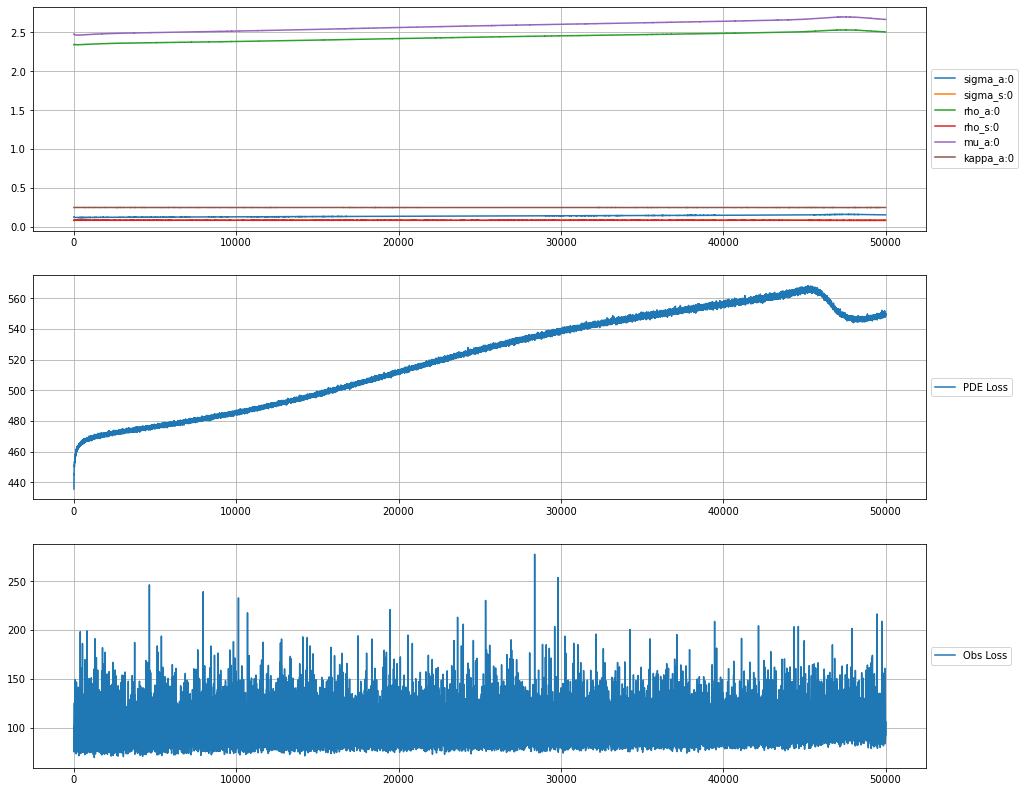

In [38]:
param_names = [v.name for v in loss_stack_1[1].trainable_vars()]
params_len = len(param_names)
W_n = len(layers)-1

start = 0

_ = plt.figure(figsize=(16,14))
plt.subplot(3,1,1)
for j in range(params_len):
    plt.plot(samples_params_5[start:,j], label=f"{param_names[j]}")

#plt.ylim([0,.28])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(3,1,2)
#plt.plot(arr_losses_3[start:,0], label="Obs Loss")
plt.plot(arr_losses_5[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim([0,8000])



plt.subplot(3,1,3)
plt.plot(arr_losses_5[start:,0], label="Obs Loss")
#plt.plot(arr_losses_3[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim([0,8000])

plt.show()

In [39]:
arr_losses_6, samples_params_6, _ = \
         model_1.train(50000,
                       batch_size=dataset['obs_input'].shape[0]//8, 
                       print_iter=100,
                       stop_threshold = 1.0,
                       regularised=False,
                       regularisation_freq=10,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:651.32
Loss_observations:100.86271095 
Loss_ASDM:550.46155548 sigma_a:0:0.15515450, sigma_s:0:0.08589356, rho_a:0:2.50302029, rho_s:0:0.08522233, mu_a:0:2.66267371, kappa_a:0:0.24985977
Time:0.69

Epoch: 100, loss:637.01
Loss_observations:86.91428375 
Loss_ASDM:550.09149933 sigma_a:0:0.15446419, sigma_s:0:0.08623880, rho_a:0:2.50182414, rho_s:0:0.08490936, mu_a:0:2.66140819, kappa_a:0:0.24995151
Time:79.97

Epoch: 200, loss:651.87
Loss_observations:101.25644875 
Loss_ASDM:550.61577606 sigma_a:0:0.15454285, sigma_s:0:0.08581506, rho_a:0:2.50093389, rho_s:0:0.08501059, mu_a:0:2.65995312, kappa_a:0:0.24986067
Time:85.00

Epoch: 300, loss:656.66
Loss_observations:106.56379509 
Loss_ASDM:550.09594727 sigma_a:0:0.15442277, sigma_s:0:0.08526938, rho_a:0:2.50009370, rho_s:0:0.08546340, mu_a:0:2.65845060, kappa_a:0:0.24984024
Time:80.08

Epoch: 400, loss:658.18
Loss_observations:107.51017475 
Loss_ASDM:550.66798401 sigma_a:0:0.15407132, sigma_s:0:0.08559746, rho_a:0:2.49929667, r

Epoch: 3900, loss:646.96
Loss_observations:89.73837376 
Loss_ASDM:557.21691513 sigma_a:0:0.15225141, sigma_s:0:0.08591129, rho_a:0:2.49662519, rho_s:0:0.08527324, mu_a:0:2.65101409, kappa_a:0:0.25024247
Time:82.49

Epoch: 4000, loss:649.48
Loss_observations:91.36470127 
Loss_ASDM:558.11482239 sigma_a:0:0.15198880, sigma_s:0:0.08614630, rho_a:0:2.49708843, rho_s:0:0.08518218, mu_a:0:2.65172100, kappa_a:0:0.25040722
Time:83.26

Epoch: 4100, loss:665.62
Loss_observations:107.41505623 
Loss_ASDM:558.20722961 sigma_a:0:0.15177490, sigma_s:0:0.08596580, rho_a:0:2.49749279, rho_s:0:0.08548025, mu_a:0:2.65246773, kappa_a:0:0.25037000
Time:86.54

Epoch: 4200, loss:666.74
Loss_observations:108.30487823 
Loss_ASDM:558.43334198 sigma_a:0:0.15228379, sigma_s:0:0.08569153, rho_a:0:2.49793005, rho_s:0:0.08516633, mu_a:0:2.65283656, kappa_a:0:0.25056997
Time:82.30

Epoch: 4300, loss:674.16
Loss_observations:114.59522152 
Loss_ASDM:559.56079865 sigma_a:0:0.15217339, sigma_s:0:0.08602699, rho_a:0:2.4983

Epoch: 7800, loss:689.49
Loss_observations:117.38689709 
Loss_ASDM:572.10523224 sigma_a:0:0.15644093, sigma_s:0:0.08584839, rho_a:0:2.52359152, rho_s:0:0.08561355, mu_a:0:2.68151593, kappa_a:0:0.25048909
Time:90.81

Epoch: 7900, loss:678.73
Loss_observations:105.82386971 
Loss_ASDM:572.90258789 sigma_a:0:0.15617833, sigma_s:0:0.08547673, rho_a:0:2.52403879, rho_s:0:0.08543725, mu_a:0:2.68297219, kappa_a:0:0.25055358
Time:88.72

Epoch: 8000, loss:683.68
Loss_observations:110.34521580 
Loss_ASDM:573.33078766 sigma_a:0:0.15645392, sigma_s:0:0.08598397, rho_a:0:2.52504373, rho_s:0:0.08521470, mu_a:0:2.68390584, kappa_a:0:0.25070402
Time:96.31

Epoch: 8100, loss:667.51
Loss_observations:95.12754059 
Loss_ASDM:572.37911987 sigma_a:0:0.15710348, sigma_s:0:0.08599556, rho_a:0:2.52603698, rho_s:0:0.08517417, mu_a:0:2.68488812, kappa_a:0:0.25064424
Time:91.29

Epoch: 8200, loss:679.98
Loss_observations:105.53993130 
Loss_ASDM:574.43804169 sigma_a:0:0.15669875, sigma_s:0:0.08580641, rho_a:0:2.526

Epoch: 11600, loss:716.41
Loss_observations:121.16076279 
Loss_ASDM:595.25110626 sigma_a:0:0.16361561, sigma_s:0:0.08533252, rho_a:0:2.55944324, rho_s:0:0.08487538, mu_a:0:2.72477150, kappa_a:0:0.25051251
Time:83.24

Epoch: 11700, loss:698.50
Loss_observations:101.60834599 
Loss_ASDM:596.88952637 sigma_a:0:0.16352691, sigma_s:0:0.08543491, rho_a:0:2.56029534, rho_s:0:0.08464543, mu_a:0:2.72614384, kappa_a:0:0.25037315
Time:85.12

Epoch: 11800, loss:700.36
Loss_observations:102.15567017 
Loss_ASDM:598.20120239 sigma_a:0:0.16317163, sigma_s:0:0.08561993, rho_a:0:2.56104708, rho_s:0:0.08461602, mu_a:0:2.72748065, kappa_a:0:0.25067279
Time:83.67

Epoch: 11900, loss:726.67
Loss_observations:128.06509304 
Loss_ASDM:598.60723877 sigma_a:0:0.16387153, sigma_s:0:0.08544275, rho_a:0:2.56195712, rho_s:0:0.08481170, mu_a:0:2.72853708, kappa_a:0:0.25066200
Time:83.24

Epoch: 12000, loss:704.53
Loss_observations:107.21844006 
Loss_ASDM:597.30953979 sigma_a:0:0.16394992, sigma_s:0:0.08556938, rho_a:0

Epoch: 15400, loss:740.95
Loss_observations:115.96642971 
Loss_ASDM:624.98313904 sigma_a:0:0.17037885, sigma_s:0:0.08468296, rho_a:0:2.59317398, rho_s:0:0.08402173, mu_a:0:2.76568604, kappa_a:0:0.25044981
Time:81.78

Epoch: 15500, loss:731.80
Loss_observations:107.99101734 
Loss_ASDM:623.81133270 sigma_a:0:0.17002903, sigma_s:0:0.08496501, rho_a:0:2.59406519, rho_s:0:0.08391710, mu_a:0:2.76716304, kappa_a:0:0.25055608
Time:83.75

Epoch: 15600, loss:739.53
Loss_observations:113.20570946 
Loss_ASDM:626.32769775 sigma_a:0:0.17057839, sigma_s:0:0.08460905, rho_a:0:2.59509659, rho_s:0:0.08373649, mu_a:0:2.76832247, kappa_a:0:0.25071299
Time:84.53

Epoch: 15700, loss:747.00
Loss_observations:120.89104748 
Loss_ASDM:626.10430908 sigma_a:0:0.17042498, sigma_s:0:0.08494561, rho_a:0:2.59622383, rho_s:0:0.08408109, mu_a:0:2.76961493, kappa_a:0:0.25051463
Time:86.41

Epoch: 15800, loss:732.69
Loss_observations:104.34189129 
Loss_ASDM:628.34550476 sigma_a:0:0.17058389, sigma_s:0:0.08489864, rho_a:0

Epoch: 19200, loss:766.94
Loss_observations:102.09881020 
Loss_ASDM:664.84606934 sigma_a:0:0.18007404, sigma_s:0:0.08351225, rho_a:0:2.63752198, rho_s:0:0.08352202, mu_a:0:2.82088804, kappa_a:0:0.25011966
Time:96.92

Epoch: 19300, loss:767.97
Loss_observations:101.56955147 
Loss_ASDM:666.40039825 sigma_a:0:0.18056618, sigma_s:0:0.08393449, rho_a:0:2.63863111, rho_s:0:0.08279140, mu_a:0:2.82239366, kappa_a:0:0.25008681
Time:88.98

Epoch: 19400, loss:774.74
Loss_observations:110.10142326 
Loss_ASDM:664.64178467 sigma_a:0:0.18118301, sigma_s:0:0.08319296, rho_a:0:2.64010906, rho_s:0:0.08358497, mu_a:0:2.82388639, kappa_a:0:0.24983267
Time:86.91

Epoch: 19500, loss:767.54
Loss_observations:101.42817020 
Loss_ASDM:666.11564636 sigma_a:0:0.18151323, sigma_s:0:0.08279913, rho_a:0:2.64137411, rho_s:0:0.08367649, mu_a:0:2.82567763, kappa_a:0:0.24998342
Time:90.80

Epoch: 19600, loss:779.73
Loss_observations:109.87529278 
Loss_ASDM:669.85855103 sigma_a:0:0.18154137, sigma_s:0:0.08341578, rho_a:0

Epoch: 23000, loss:847.65
Loss_observations:129.44398689 
Loss_ASDM:718.20509338 sigma_a:0:0.19571111, sigma_s:0:0.08251937, rho_a:0:2.70534086, rho_s:0:0.08276881, mu_a:0:2.90556049, kappa_a:0:0.24929482
Time:90.03

Epoch: 23100, loss:850.79
Loss_observations:131.14460754 
Loss_ASDM:719.64522552 sigma_a:0:0.19630477, sigma_s:0:0.08246782, rho_a:0:2.70754075, rho_s:0:0.08232091, mu_a:0:2.90893269, kappa_a:0:0.24960439
Time:89.55

Epoch: 23200, loss:846.96
Loss_observations:124.43584061 
Loss_ASDM:722.52519989 sigma_a:0:0.19663236, sigma_s:0:0.08275645, rho_a:0:2.70993924, rho_s:0:0.08235206, mu_a:0:2.91212320, kappa_a:0:0.24976625
Time:94.75

Epoch: 23300, loss:849.55
Loss_observations:125.69725800 
Loss_ASDM:723.85283661 sigma_a:0:0.19791210, sigma_s:0:0.08318640, rho_a:0:2.71289754, rho_s:0:0.08200308, mu_a:0:2.91537952, kappa_a:0:0.24970077
Time:99.80

Epoch: 23400, loss:849.75
Loss_observations:122.86029816 
Loss_ASDM:726.89209747 sigma_a:0:0.19838613, sigma_s:0:0.08236130, rho_a:0

Epoch: 26800, loss:1200.40
Loss_observations:168.69235420 
Loss_ASDM:1031.70923615 sigma_a:0:0.24475993, sigma_s:0:0.07771320, rho_a:0:2.91202211, rho_s:0:0.07874902, mu_a:0:3.17141175, kappa_a:0:0.24680080
Time:90.39

Epoch: 26900, loss:1207.07
Loss_observations:167.19140053 
Loss_ASDM:1039.88223267 sigma_a:0:0.24811219, sigma_s:0:0.07738154, rho_a:0:2.92564297, rho_s:0:0.07790910, mu_a:0:3.18912005, kappa_a:0:0.24630129
Time:89.71

Epoch: 27000, loss:1266.27
Loss_observations:164.83388901 
Loss_ASDM:1101.43319702 sigma_a:0:0.25261250, sigma_s:0:0.07687142, rho_a:0:2.94144583, rho_s:0:0.07698616, mu_a:0:3.20969677, kappa_a:0:0.24562867
Time:88.34

Epoch: 27100, loss:1341.38
Loss_observations:176.67013359 
Loss_ASDM:1164.71446228 sigma_a:0:0.25663549, sigma_s:0:0.07608245, rho_a:0:2.95826626, rho_s:0:0.07686335, mu_a:0:3.23396611, kappa_a:0:0.24551909
Time:92.21

Epoch: 27200, loss:1404.87
Loss_observations:182.23930550 
Loss_ASDM:1222.63452911 sigma_a:0:0.26267713, sigma_s:0:0.0769076

Epoch: 30600, loss:47113.19
Loss_observations:886.52291870 
Loss_ASDM:46226.66619873 sigma_a:0:0.47016853, sigma_s:0:0.04819311, rho_a:0:3.79100871, rho_s:0:0.05087753, mu_a:0:4.33908892, kappa_a:0:0.23643517
Time:87.28

Epoch: 30700, loss:1205907.50
Loss_observations:50738.91064453 
Loss_ASDM:1155168.58886719 sigma_a:0:0.28456417, sigma_s:0:0.01646949, rho_a:0:3.83731723, rho_s:0:0.00000000, mu_a:0:4.65173912, kappa_a:0:0.07950812
Time:86.58

Epoch: 30800, loss:457941728.00
Loss_observations:2839224.40625000 
Loss_ASDM:455102508.87500000 sigma_a:0:0.00000000, sigma_s:0:0.02831788, rho_a:0:4.49930000, rho_s:0:0.00000000, mu_a:0:5.36323833, kappa_a:0:0.00000000
Time:85.44

Epoch: 30900, loss:513316096.00
Loss_observations:6518678.06250000 
Loss_ASDM:506797406.00000000 sigma_a:0:0.00000000, sigma_s:0:0.00000000, rho_a:0:4.84818029, rho_s:0:0.00000000, mu_a:0:5.41467667, kappa_a:0:0.00000000
Time:86.53

Epoch: 31000, loss:2721067264.00
Loss_observations:6045982.18750000 
Loss_ASDM:2715021

Epoch: 34200, loss:219512560.00
Loss_observations:2282893.60937500 
Loss_ASDM:217229664.00000000 sigma_a:0:0.00000000, sigma_s:0:0.00010922, rho_a:0:7.57870626, rho_s:0:0.00000000, mu_a:0:4.71576834, kappa_a:0:0.00002787
Time:90.69

Epoch: 34300, loss:137754544.00
Loss_observations:2313860.89062500 
Loss_ASDM:135440688.00000000 sigma_a:0:0.00000000, sigma_s:0:0.01211062, rho_a:0:7.56940889, rho_s:0:0.00000000, mu_a:0:4.77035475, kappa_a:0:0.00000644
Time:92.48

Epoch: 34400, loss:145769616.00
Loss_observations:2478884.68750000 
Loss_ASDM:143290724.50000000 sigma_a:0:0.00000000, sigma_s:0:0.04666441, rho_a:0:7.56766462, rho_s:0:0.00000000, mu_a:0:4.90165234, kappa_a:0:0.00000000
Time:87.14

Epoch: 34500, loss:234133920.00
Loss_observations:2247056.87500000 
Loss_ASDM:231886867.25000000 sigma_a:0:0.00000000, sigma_s:0:0.01035346, rho_a:0:7.57930660, rho_s:0:0.00000000, mu_a:0:5.09943199, kappa_a:0:0.00000000
Time:87.85

Epoch: 34600, loss:151468096.00
Loss_observations:2523366.78125000 


Epoch: 37800, loss:667648192.00
Loss_observations:3291131.59375000 
Loss_ASDM:664357060.00000000 sigma_a:0:5.72111988, sigma_s:0:0.18797366, rho_a:0:9.58186626, rho_s:0:0.00000000, mu_a:0:9.99319458, kappa_a:0:0.00000000
Time:86.55

Epoch: 37900, loss:68072984.00
Loss_observations:2557853.79687500 
Loss_ASDM:65515132.00000000 sigma_a:0:5.24925518, sigma_s:0:0.28306100, rho_a:0:9.58176136, rho_s:0:0.00000000, mu_a:0:10.24196339, kappa_a:0:0.00000000
Time:87.83

Epoch: 38000, loss:90077112.00
Loss_observations:2280615.92187500 
Loss_ASDM:87796487.87500000 sigma_a:0:4.72275448, sigma_s:0:0.25088298, rho_a:0:9.58329582, rho_s:0:0.00000000, mu_a:0:10.58089542, kappa_a:0:0.00000000
Time:87.67

Epoch: 38100, loss:90740144.00
Loss_observations:1836508.34375000 
Loss_ASDM:88903637.00000000 sigma_a:0:4.57296658, sigma_s:0:0.29716557, rho_a:0:9.59033489, rho_s:0:0.00000000, mu_a:0:11.08774948, kappa_a:0:0.00000000
Time:92.38

Epoch: 38200, loss:36239164.00
Loss_observations:1715022.51562500 
Loss

Epoch: 41300, loss:45809041408.00
Loss_observations:24673656.00000000 
Loss_ASDM:45784368768.00000000 sigma_a:0:8.54920959, sigma_s:0:0.82460344, rho_a:0:12.06766224, rho_s:0:0.00000000, mu_a:0:13.86314297, kappa_a:0:0.00000000
Time:89.63

Epoch: 41400, loss:107542052864.00
Loss_observations:27343557.50000000 
Loss_ASDM:107514705408.00000000 sigma_a:0:8.64125347, sigma_s:0:0.70148867, rho_a:0:12.35379219, rho_s:0:0.00000000, mu_a:0:13.51418304, kappa_a:0:0.00000000
Time:89.94

Epoch: 41500, loss:78269448192.00
Loss_observations:45868530.50000000 
Loss_ASDM:78223576320.00000000 sigma_a:0:8.62253380, sigma_s:0:0.71092576, rho_a:0:12.77492619, rho_s:0:0.00000000, mu_a:0:13.10089684, kappa_a:0:0.00000000
Time:89.84

Epoch: 41600, loss:126976966656.00
Loss_observations:62254916.50000000 
Loss_ASDM:126914717632.00000000 sigma_a:0:8.51207256, sigma_s:0:0.67241567, rho_a:0:13.03952217, rho_s:0:0.00000000, mu_a:0:12.85494614, kappa_a:0:0.00000000
Time:89.73

Epoch: 41700, loss:26159349760.00
Lo

Epoch: 44800, loss:307743064064.00
Loss_observations:18711117.50000000 
Loss_ASDM:307724358144.00000000 sigma_a:0:4.47019386, sigma_s:0:1.01806247, rho_a:0:16.51180649, rho_s:0:0.00000000, mu_a:0:4.42020416, kappa_a:0:0.01692054
Time:88.73

Epoch: 44900, loss:110358413312.00
Loss_observations:20607243.00000000 
Loss_ASDM:110337808576.00000000 sigma_a:0:4.78548527, sigma_s:0:1.14439130, rho_a:0:16.55834198, rho_s:0:0.00000000, mu_a:0:4.34501362, kappa_a:0:0.01079024
Time:87.40

Epoch: 45000, loss:67654000640.00
Loss_observations:19016786.00000000 
Loss_ASDM:67634980288.00000000 sigma_a:0:5.19918728, sigma_s:0:1.41451943, rho_a:0:16.57541656, rho_s:0:0.00000000, mu_a:0:4.32383633, kappa_a:0:0.00746058
Time:87.78

Epoch: 45100, loss:470157754368.00
Loss_observations:22766047.50000000 
Loss_ASDM:470134941696.00000000 sigma_a:0:5.15843201, sigma_s:0:1.46058226, rho_a:0:16.75363922, rho_s:0:0.00000000, mu_a:0:3.93903494, kappa_a:0:0.01413143
Time:90.36

Epoch: 45200, loss:1322293264384.00
Lo

Epoch: 48300, loss:42594881536.00
Loss_observations:8948097.25000000 
Loss_ASDM:42585930496.00000000 sigma_a:0:3.42738724, sigma_s:0:1.52726471, rho_a:0:19.19537354, rho_s:0:0.00000000, mu_a:0:0.00021062, kappa_a:0:0.01521895
Time:87.85

Epoch: 48400, loss:1018174832640.00
Loss_observations:24097685.75000000 
Loss_ASDM:1018150737408.00000000 sigma_a:0:2.89012861, sigma_s:0:1.27864897, rho_a:0:19.22903633, rho_s:0:0.00000000, mu_a:0:0.00000000, kappa_a:0:0.03168137
Time:94.43

Epoch: 48500, loss:313265815552.00
Loss_observations:19545992.00000000 
Loss_ASDM:313246278016.00000000 sigma_a:0:3.50090337, sigma_s:0:1.89143705, rho_a:0:19.23719406, rho_s:0:0.00000000, mu_a:0:0.00000000, kappa_a:0:0.03143370
Time:88.63

Epoch: 48600, loss:202585407488.00
Loss_observations:17917464.25000000 
Loss_ASDM:202567500032.00000000 sigma_a:0:3.89934182, sigma_s:0:2.45632744, rho_a:0:19.24306488, rho_s:0:0.00000000, mu_a:0:0.00071613, kappa_a:0:0.03128861
Time:91.86

Epoch: 48700, loss:115998105600.00
Lo

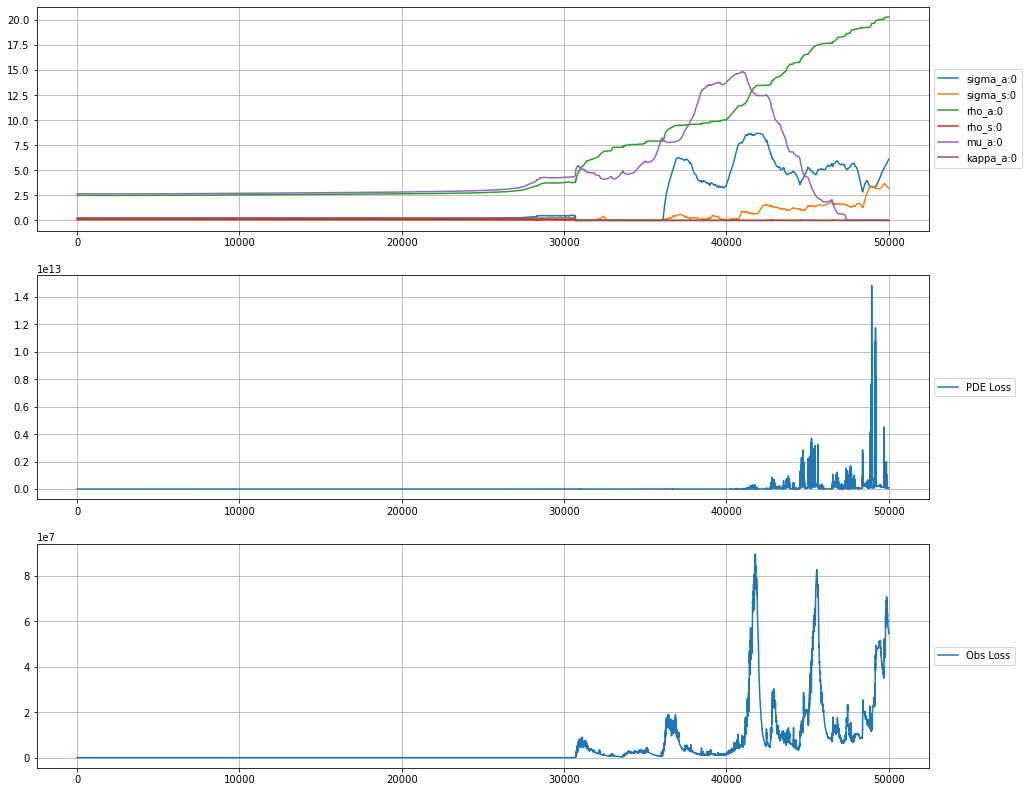

In [40]:
param_names = [v.name for v in loss_stack_1[1].trainable_vars()]
params_len = len(param_names)
W_n = len(layers)-1

start = 0

_ = plt.figure(figsize=(16,14))
plt.subplot(3,1,1)
for j in range(params_len):
    plt.plot(samples_params_6[start:,j], label=f"{param_names[j]}")

#plt.ylim([0,.28])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(3,1,2)
#plt.plot(arr_losses_3[start:,0], label="Obs Loss")
plt.plot(arr_losses_6[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim([0,8000])



plt.subplot(3,1,3)
plt.plot(arr_losses_6[start:,0], label="Obs Loss")
#plt.plot(arr_losses_3[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim([0,8000])

plt.show()

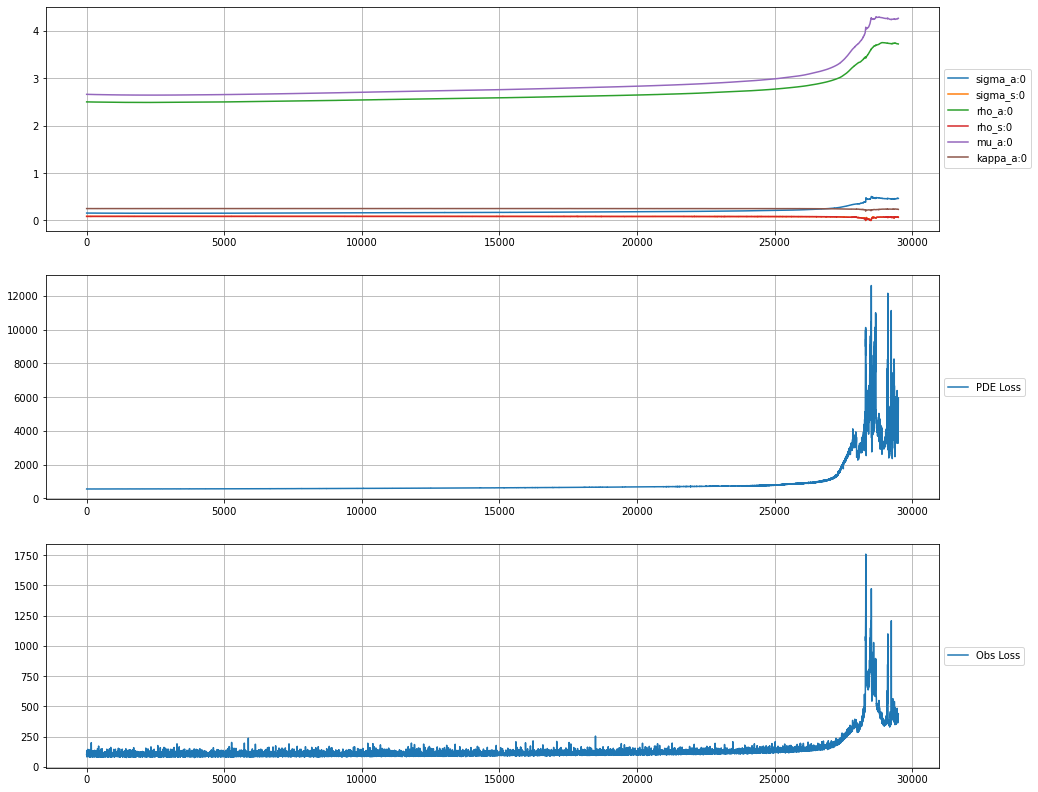

In [47]:
param_names = [v.name for v in loss_stack_1[1].trainable_vars()]
params_len = len(param_names)
W_n = len(layers)-1

start = 0
end = 29500

_ = plt.figure(figsize=(16,14))
plt.subplot(3,1,1)
for j in range(params_len):
    plt.plot(samples_params_6[start:end,j], label=f"{param_names[j]}")

#plt.ylim([0,.28])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(3,1,2)
#plt.plot(arr_losses_3[start:,0], label="Obs Loss")
plt.plot(arr_losses_6[start:end,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim([0,8000])



plt.subplot(3,1,3)
plt.plot(arr_losses_6[start:end,0], label="Obs Loss")
#plt.plot(arr_losses_3[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim([0,8000])

plt.show()

In [51]:
arr_losses = np.vstack([arr_losses_1, arr_losses_2, arr_losses_3,
                   arr_losses_4, arr_losses_5, arr_losses_6])

samples_params = np.vstack([samples_params_1, samples_params_2, samples_params_3,
                       samples_params_4, samples_params_5, samples_params_6])

In [52]:
arr_losses.shape

(200100, 2)

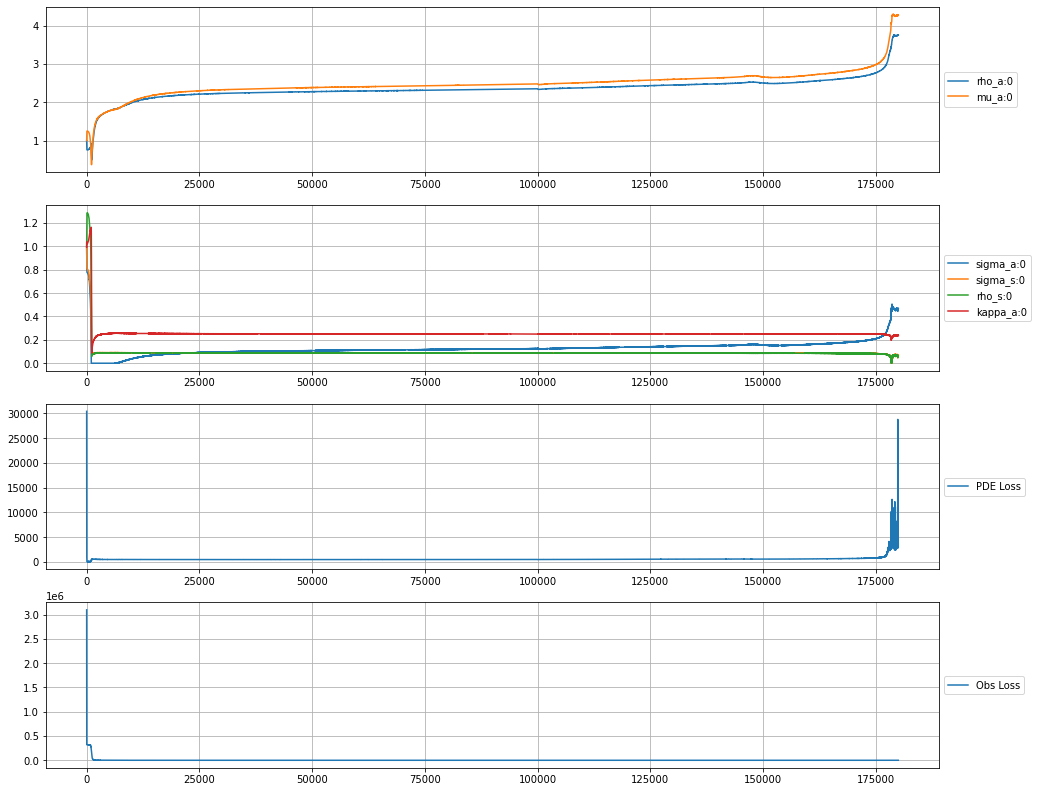

In [80]:
param_names = [v.name for v in loss_stack_1[1].trainable_vars()]
params_len = len(param_names)
W_n = len(layers)-1

start = 0
end = 180000

fig = plt.figure(figsize=(16,14))
fig.patch.set_facecolor('white')

plt.subplot(4,1,1)
for j in [2,4]:#range(params_len):
    plt.plot(samples_params[start:end,j], label=f"{param_names[j]}")

#plt.ylim([0,.28])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.subplot(4,1,2)
for j in [0,1,3,5]:#range(params_len):
    plt.plot(samples_params[start:end,j], label=f"{param_names[j]}")

#plt.ylim([0,.28])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(4,1,3)
plt.plot(arr_losses[start:end,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim([0,8000])



plt.subplot(4,1,4)
plt.plot(arr_losses[start:end,0], label="Obs Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim([0,8000])

plt.show()

In [73]:
np.save('./outputs/long_diverging_run_losses.npy', arr_losses)
np.save('./outputs/long_diverging_run_params.npy', samples_params)
np.save('./outputs/long_diverging_run_param_names.npy',param_names)